In [12]:
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")


In [22]:
from sklearn.model_selection import GroupKFold
import lightgbm as lgb
import xgboost as xgb
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import RocCurveDisplay

In [23]:
def preprocess(df):
    df.Tx = df.Tx.apply(lambda x: 0 if x=='0:C' else 1).values.tolist()
    
    df.Tier = df.Tier.apply(lambda x: 1 if x=='Tier 1' else x).values.tolist()
    df.Tier = df.Tier.apply(lambda x: 2 if x=='Tier 2' else x).values.tolist()
    df.Tier = df.Tier.apply(lambda x: 3 if x=='Tier 3' else x).values.tolist()
    df.Cohort = df.Cohort.apply(lambda x: 1 if x=='Study 1' else 2).values.tolist()
    

In [20]:
column_names = ['StuID', 'Gender', 'Tier', 'SchlID', 'TeachID', 'LEP',
       'SpEd', 'Tx', 'Cohort', 'Keep', 'Age1b', 'Tier2_N', 'grp_rate',
       'rcmistot', 'gnrl_fid', 'TKPctCrct', 'Tier2MinRd', 'TYearsTeaching',
       'Time', 't', 'NWFcls', 'NWFwrc', 'ORFwc', 'SAwrS', 'SAsrS', 'SAtoS',
       'RMwidRS', 'RMwdaRS']
df = pd.read_spss("./Ms_Study12Tier12.sav", usecols=column_names)

data = df.dropna()
data_t0 = data[data['t']==0]
data_t1 = data[data['t']==1]

preprocess(data_t0)
preprocess(data_t1)

data_merged = data_t0.merge(data_t1, how = 'inner', on='StuID')

In [24]:
data_ctrl = data_merged[data_merged["Tx_x"]==0]
data_intn = data_merged[data_merged["Tx_x"]==1]

RMwidRS_ref = np.mean(data_ctrl.iloc[:, 53]-data_ctrl.iloc[:, 26])
RMwdaRS_ref = np.mean(data_ctrl.iloc[:, 54]-data_ctrl.iloc[:, 27])



data_merged["RMwidRS_target"] = (data_merged.RMwidRS_y-data_merged.RMwidRS_x).apply(lambda x: 0 if x-RMwidRS_ref<0 else 1)
data_merged["RMwdaRS_target"] = (data_merged.RMwdaRS_y-data_merged.RMwdaRS_x).apply(lambda x: 0 if x-RMwdaRS_ref<0 else 1)

data_ctrl["RMwidRS_target"] = (data_ctrl.RMwidRS_y-data_ctrl.RMwidRS_x).apply(lambda x: 0 if x-RMwidRS_ref<0 else 1)
data_ctrl["RMwdaRS_target"] = (data_ctrl.RMwdaRS_y-data_ctrl.RMwdaRS_x).apply(lambda x: 0 if x-RMwdaRS_ref<0 else 1)

data_intn["RMwidRS_target"] = (data_intn.RMwidRS_y-data_intn.RMwidRS_x).apply(lambda x: 0 if x-RMwidRS_ref<0 else 1)
data_intn["RMwdaRS_target"] = (data_intn.RMwdaRS_y-data_intn.RMwdaRS_x).apply(lambda x: 0 if x-RMwdaRS_ref<0 else 1)

In [25]:
feature_columns = ['Gender_x', 'Tx_x', 'Age1b_x',  'Tier2_N_x', 'grp_rate_x',
                   'rcmistot_x', 'gnrl_fid_x', 'TKPctCrct_x', 'NWFcls_x', 
                   'NWFwrc_x', 'ORFwc_x', 'SAwrS_x', 'SAsrS_x', 'SAtoS_x',
                   'RMwidRS_x', 'RMwdaRS_x',
                   'Tier_x', 'TeachID_x', 'LEP_x', 'SpEd_x', 'Cohort_x', 'Keep_x', 'Tier2MinRd_x', 'TYearsTeaching_x', 'Time_x', 'SchlID_x'
                  ]
feature_columns_noTx = ['Gender_x', 'Age1b_x',  'Tier2_N_x', 'grp_rate_x',
                   'rcmistot_x', 'gnrl_fid_x', 'TKPctCrct_x', 'NWFcls_x', 
                   'NWFwrc_x', 'ORFwc_x', 'SAwrS_x', 'SAsrS_x', 'SAtoS_x',
                   'RMwidRS_x', 'RMwdaRS_x']

selected_features_wid = ["Tier2_N_x", "TKPctCrct_x", "NWFwrc_x",  'SAsrS_x', 'SAtoS_x', 'RMwidRS_x', 'RMwdaRS_x']

selected_features_wda = ["Tx_x", "NWFwrc_x", "ORFwc_x", "SAwrS_x", "SAtoS_x", "RMwdaRS_x"]

target_columns = ["RMwidRS_target", "RMwdaRS_target"]
split_coumns= ["StuID", "SchlID_x"]

# XGBoost

In [27]:
# params = {
#     'boost_from_average':'false',
#     'boost': 'gbdt',
#     'feature_fraction': 1,
#     'learning_rate': 0.05,
#     'max_depth': -1,
#     'metric':'binary_logloss',
#     'num_leaves': 4,
#     'num_threads': 8,
#     'tree_learner': 'serial',
#     'objective': 'binary',
#     'reg_alpha': 2,
#     'reg_lambda': 0,
#     'verbosity': 1,
#     'max_bin':256,
# }

params = {'eta': 0.01,
          'random_state' : 630,
          'learning_rate': 0.15,
          'num_leaves': 36,
          'max_depth': 6,
          'metric' : ['auc'],
          'boosting_type' : 'gbdt',
          'reg_alpha' : 2.03,
          'reg_lambda' : 4.7,
          'feature_fraction' : 0.8, #colsample_bytree
          'feature_fraction_seed' : 1981, 
          'max_bins' : 100,
          'min_split_gain': 0.0148,
          'min_child_weight' : 7.835, #min_sum_hessian_in_leaf 
          'min_data_in_leaf' : 1000, #min_child_samples
          'random_state' : 1981, # Updated from 'seed'
          'subsample' : .912, #also known as Bagging fraction!
          'subsample_freq' : 200, # also known as bagging frequency!
          'is_unbalance' : True}

In [33]:
%who
RMwdaRS_ref

GroupKFold	 RMwdaRS_ref	 RMwidRS_ref	 RocCurveDisplay	 X_train	 X_valid	 acc	 accuracy	 accuracy_score	 
ax	 ba	 balanced_accuracy_score	 balanced_score	 best_features	 cols	 column_names	 data	 data_ctrl	 
data_intn	 data_merged	 data_t0	 data_t1	 df	 feature_columns	 feature_columns_noTx	 feature_importance	 fig	 
fold_importance	 fold_n	 gkf	 lgb	 model	 np	 params	 pd	 plt	 
prec	 precision_recall_fscore_support	 preprocess	 recall	 recall_score	 selected_features_wda	 selected_features_wid	 sensitivity	 sns	 
specificity	 split_coumns	 target	 target_columns	 train_idx	 val_idx	 warnings	 xgb	 y_pred	 
y_train	 y_valid	 


10.923497267759563

### All features

GroupKFold	 RMwdaRS_ref	 RMwidRS_ref	 RocCurveDisplay	 accuracy_score	 balanced_accuracy_score	 column_names	 data	 data_ctrl	 
data_intn	 data_merged	 data_t0	 data_t1	 df	 feature_columns	 feature_columns_noTx	 gkf	 lgb	 
np	 params	 pd	 plt	 precision_recall_fscore_support	 preprocess	 recall_score	 selected_features_wda	 selected_features_wid	 
sns	 split_coumns	 target_columns	 warnings	 xgb	 
fold 0 training, target :RMwidRS_target
[0]	validation_0-auc:0.69921	validation_1-auc:0.68786
[1000]	validation_0-auc:0.99984	validation_1-auc:0.64581
[2000]	validation_0-auc:0.99997	validation_1-auc:0.63746
[2007]	validation_0-auc:0.99997	validation_1-auc:0.63768
accuracy:0.6814814814814815, specificity: 0.6818181818181818, sensitivity:0.6811594202898551, balanced_score: 0.6814888010540184
fold 1 training, target :RMwidRS_target
[0]	validation_0-auc:0.73578	validation_1-auc:0.61045
[1000]	validation_0-auc:0.99995	validation_1-auc:0.61814
[2000]	validation_0-auc:1.00000	validation_1-auc:0.61

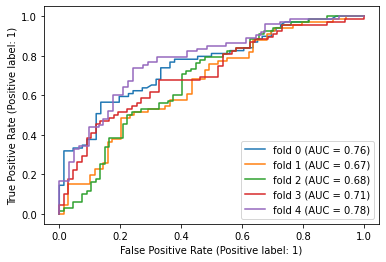

accuracy:0.6562962962962963, specificity: 0.6265955064661392, sensitivity:0.6843089480093298, balanced_score: 0.6554522272377346


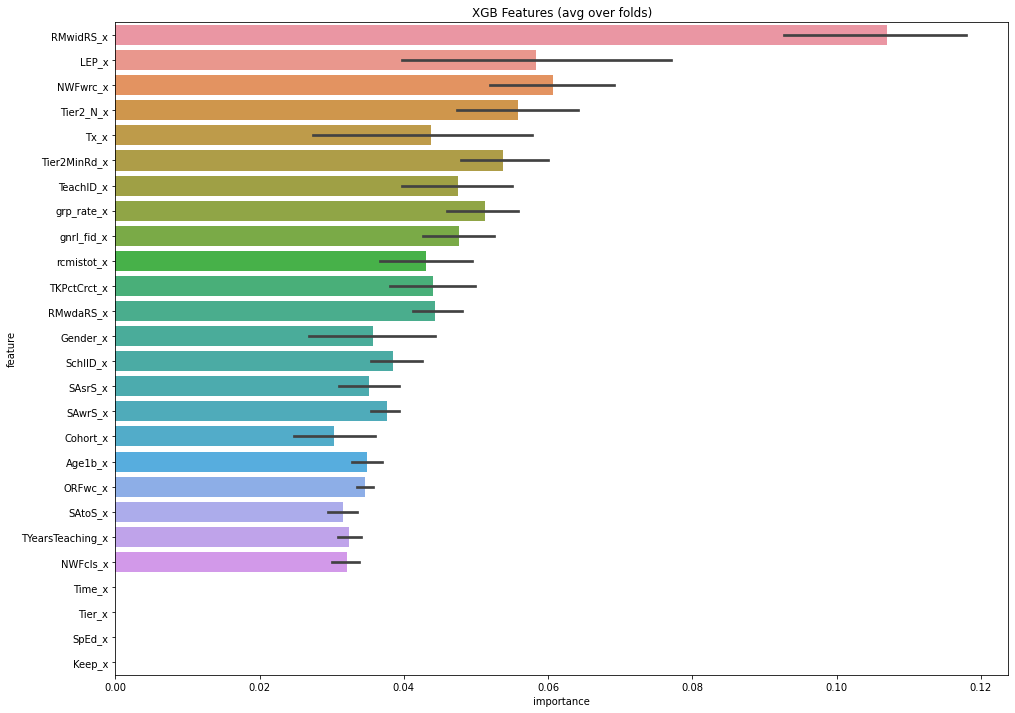

In [28]:
gkf = GroupKFold(n_splits = 5)


target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[feature_columns], data_merged[target], groups=data_merged.StuID)):
    X_train, y_train = data_merged[feature_columns].iloc[train_idx], data_merged[target].iloc[train_idx]
    X_valid, y_valid = data_merged[feature_columns].iloc[val_idx], data_merged[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[07:14:44] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.71053	validation_1-auc:0.57738
[1000]	validation_0-auc:0.99993	validation_1-auc:0.60201
[2000]	validation_0-auc:0.99996	validation_1-auc:0.59781
[2005]	validation_0-auc:0.99996	validation_1-auc:0.59804
accuracy:0.6518518518518519, specificity: 0.39215686274509803, sensitivity:0.8095238095238095, balanced_score: 0.6008403361344538
fold 1 training, target :RMwdaRS_target
[07:14:47] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.66873	validation_1-auc:0.68434
[1000]	validation_0-auc

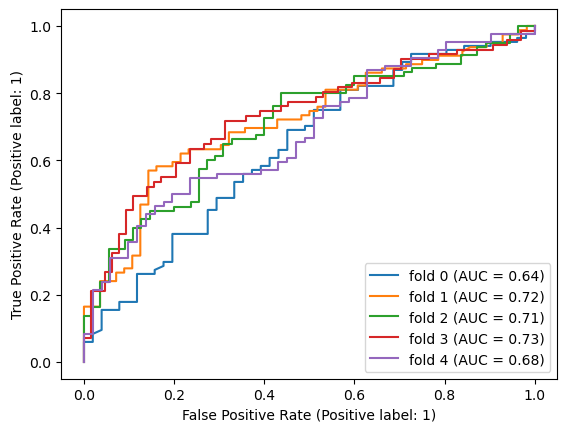

accuracy:0.6518518518518519, specificity: 0.42459702062643234, sensitivity:0.8092628980634864, balanced_score: 0.6169299593449594


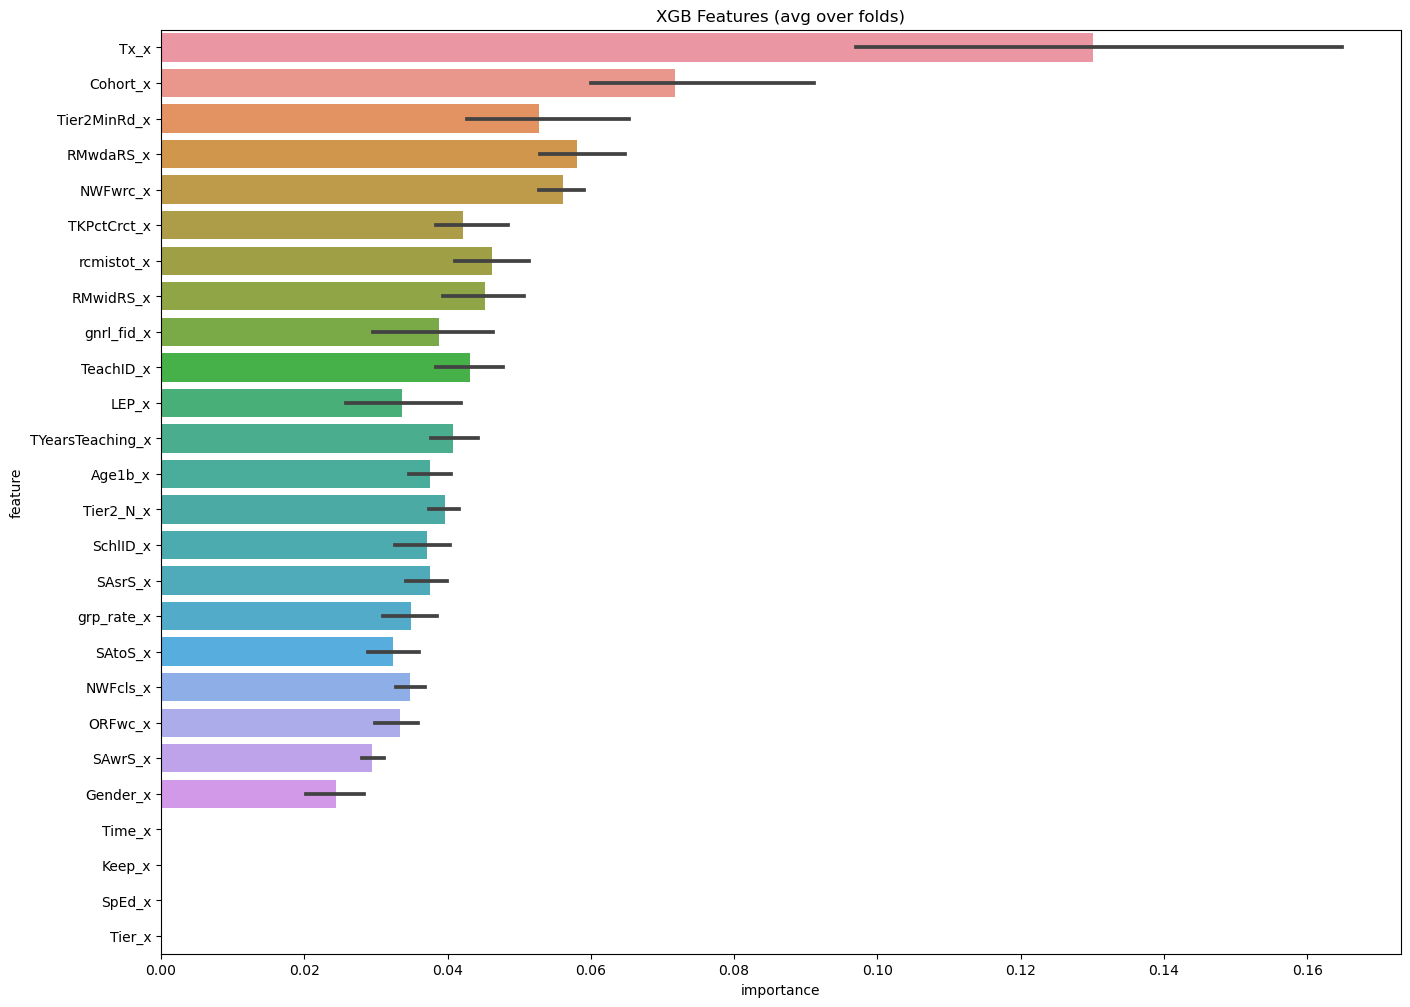

In [9]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[feature_columns], data_merged[target], groups=data_merged.StuID)):
    X_train, y_train = data_merged[feature_columns].iloc[train_idx], data_merged[target].iloc[train_idx]
    X_valid, y_valid = data_merged[feature_columns].iloc[val_idx], data_merged[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

### All features except Tx

fold 0 training, target :RMwidRS_target
[07:15:00] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.70050	validation_1-auc:0.63153
[1000]	validation_0-auc:0.99963	validation_1-auc:0.67150
[2000]	validation_0-auc:0.99993	validation_1-auc:0.65964
[2021]	validation_0-auc:0.99992	validation_1-auc:0.65810
accuracy:0.6962962962962963, specificity: 0.7424242424242424, sensitivity:0.6521739130434783, balanced_score: 0.6972990777338604
fold 1 training, target :RMwidRS_target
[07:15:02] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.73705	validation_1-auc:0.59300
[1000]	validation_0-auc:

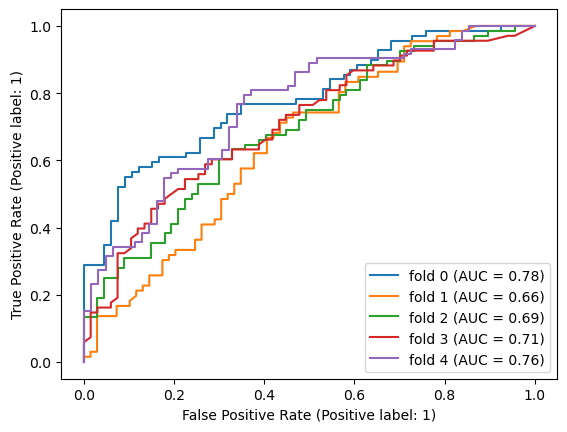

accuracy:0.6533333333333334, specificity: 0.6293477150775512, sensitivity:0.6759503736520869, balanced_score: 0.652649044364819


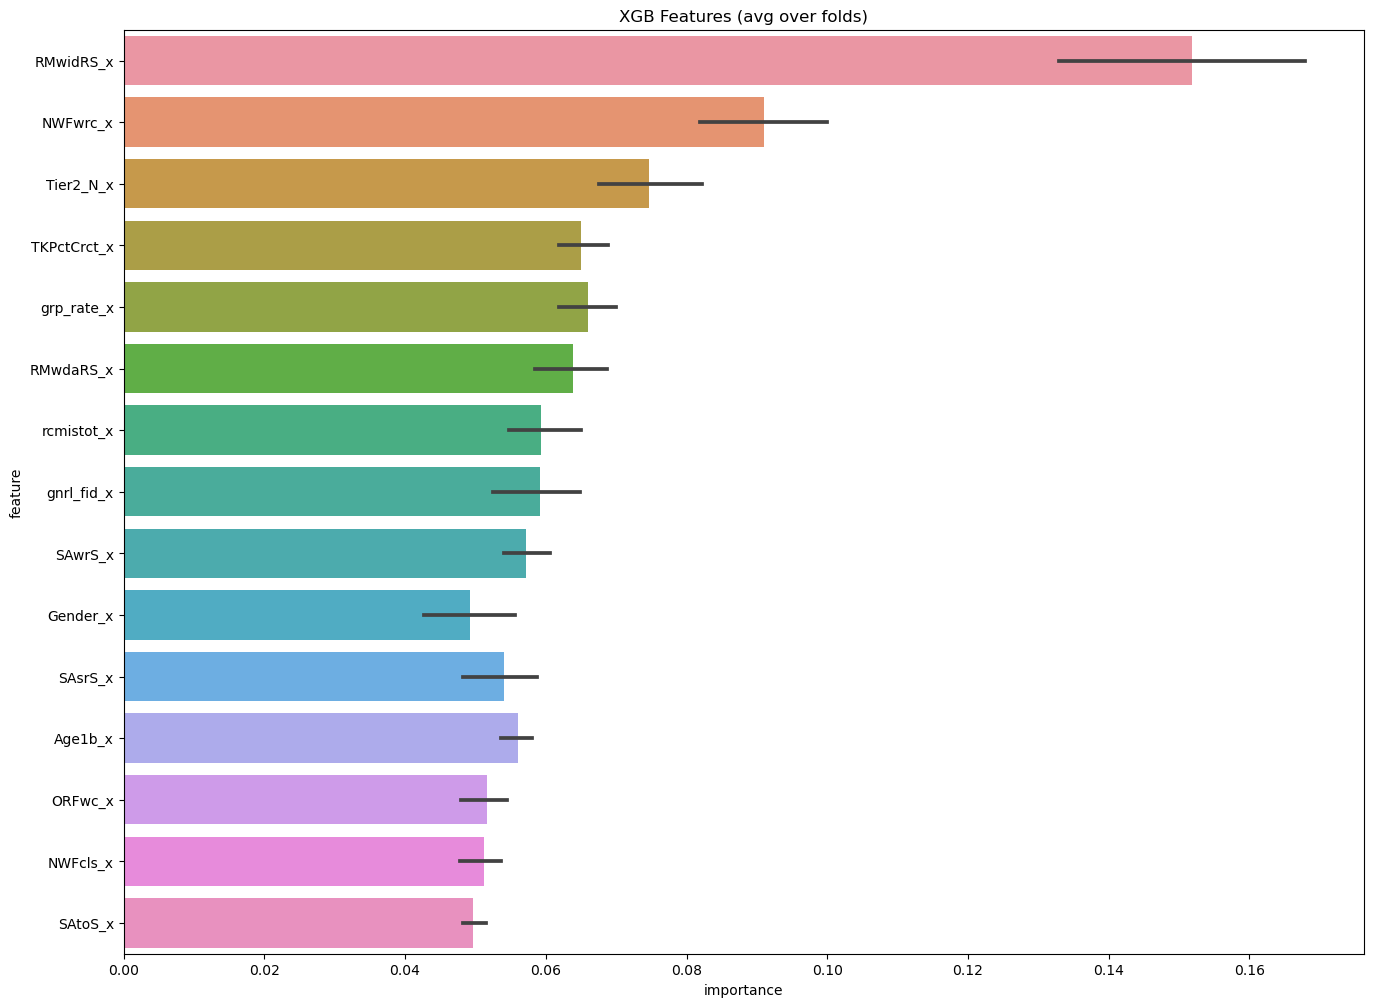

In [10]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[feature_columns_noTx], data_merged[target], groups=data_merged.StuID)):
    X_train, y_train = data_merged[feature_columns_noTx].iloc[train_idx], data_merged[target].iloc[train_idx]
    X_valid, y_valid = data_merged[feature_columns_noTx].iloc[val_idx], data_merged[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns_noTx
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[07:15:11] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.67982	validation_1-auc:0.51681
[1000]	validation_0-auc:0.99993	validation_1-auc:0.54879
[2000]	validation_0-auc:1.00000	validation_1-auc:0.54809
[2073]	validation_0-auc:1.00000	validation_1-auc:0.54715
accuracy:0.6074074074074074, specificity: 0.3333333333333333, sensitivity:0.7738095238095238, balanced_score: 0.5535714285714286
fold 1 training, target :RMwdaRS_target
[07:15:13] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.65182	validation_1-auc:0.54069
[1000]	validation_0-auc:

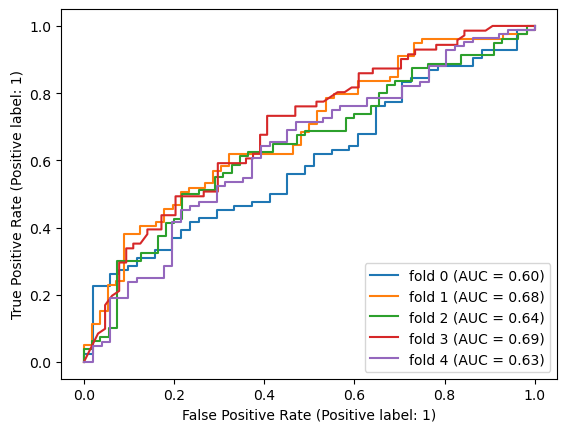

accuracy:0.6148148148148148, specificity: 0.3769114463967405, sensitivity:0.784022510590972, balanced_score: 0.5804669784938563


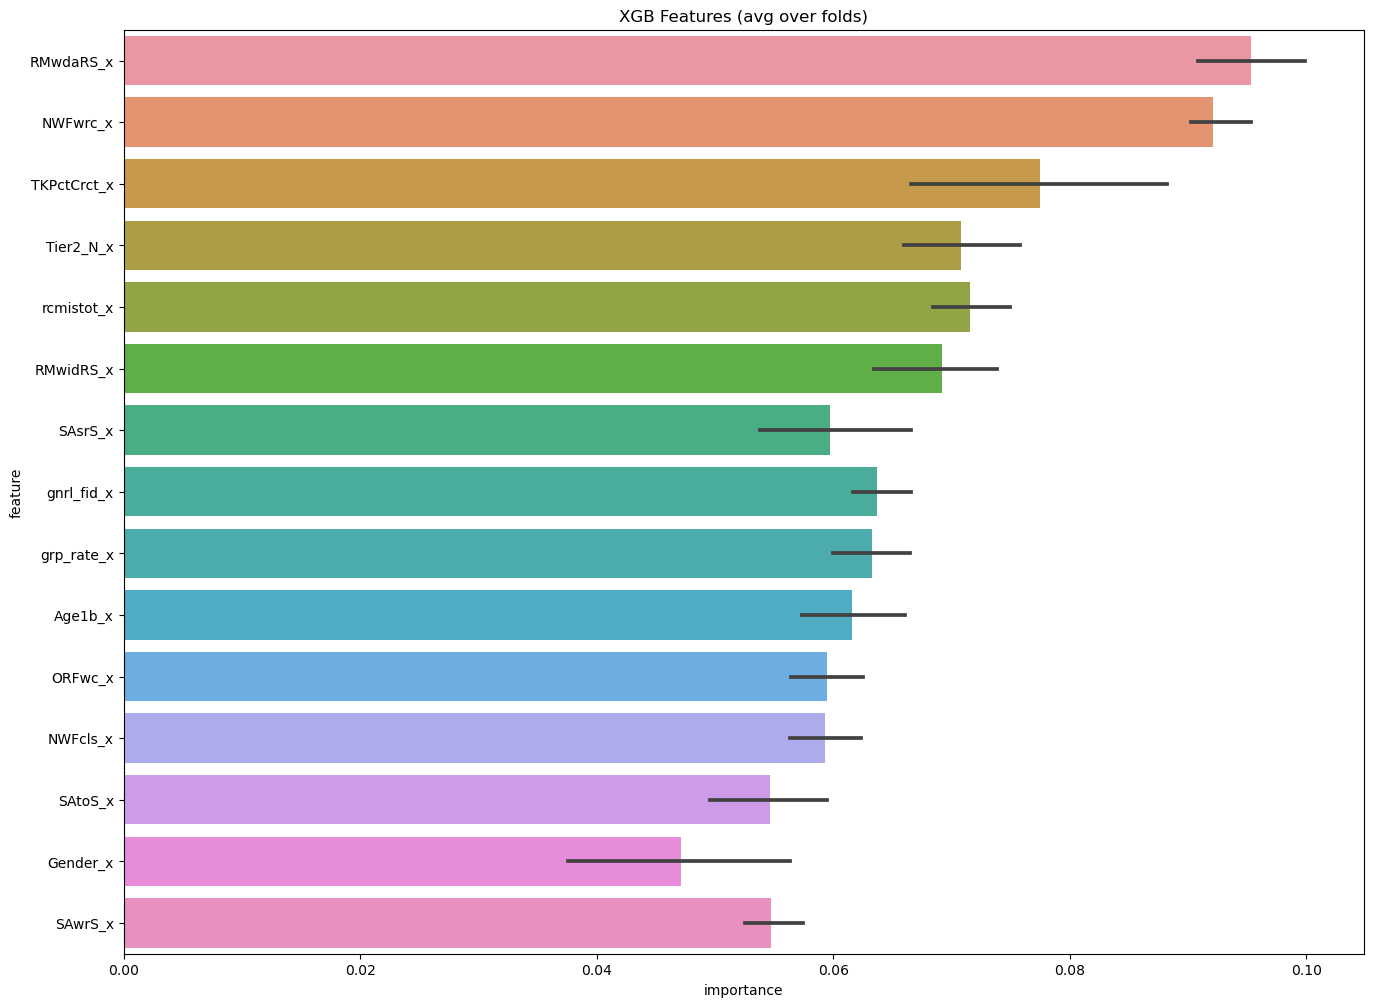

In [11]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[feature_columns_noTx], data_merged[target], groups=data_merged.StuID)):
    X_train, y_train = data_merged[feature_columns_noTx].iloc[train_idx], data_merged[target].iloc[train_idx]
    X_valid, y_valid = data_merged[feature_columns_noTx].iloc[val_idx], data_merged[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns_noTx
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

### Control group

fold 0 training, target :RMwidRS_target
[07:15:23] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.74249	validation_1-auc:0.66985
[1000]	validation_0-auc:0.99760	validation_1-auc:0.70441
[2000]	validation_0-auc:0.99934	validation_1-auc:0.70588
[2020]	validation_0-auc:0.99944	validation_1-auc:0.70735
accuracy:0.6621621621621622, specificity: 0.7941176470588235, sensitivity:0.55, balanced_score: 0.6720588235294118
fold 1 training, target :RMwidRS_target
[07:15:26] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.72905	validation_1-auc:0.58605
[1000]	validation_0-auc:0.99823	valida

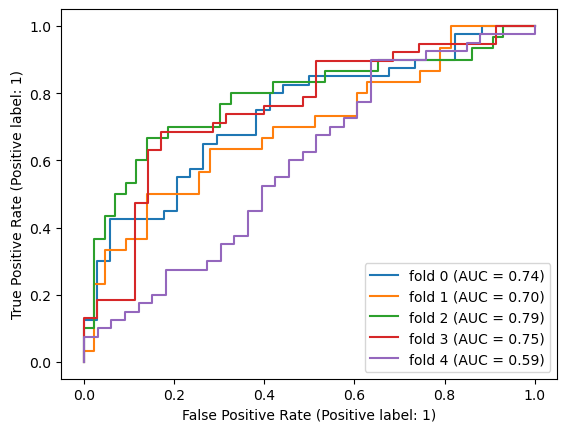

accuracy:0.652980377637912, specificity: 0.683756580856444, sensitivity:0.6223684210526315, balanced_score: 0.6530625009545379


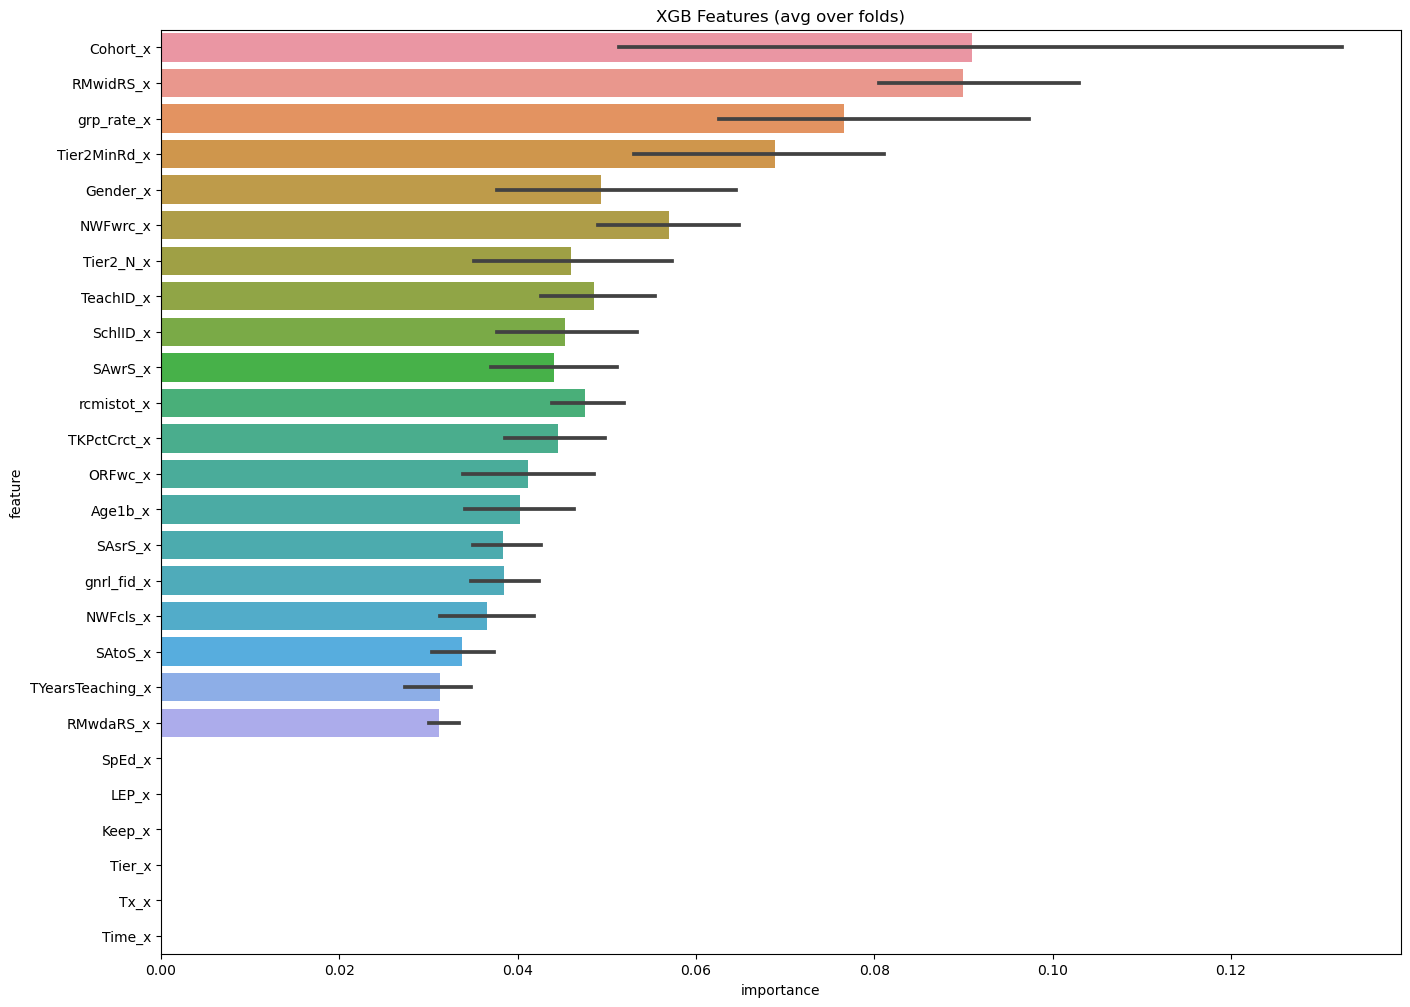

In [12]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_ctrl[feature_columns], data_ctrl[target], groups=data_ctrl.StuID)):
    X_train, y_train = data_ctrl[feature_columns].iloc[train_idx], data_ctrl[target].iloc[train_idx]
    X_valid, y_valid = data_ctrl[feature_columns].iloc[val_idx], data_ctrl[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[07:15:36] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.64732	validation_1-auc:0.52328
[1000]	validation_0-auc:0.99784	validation_1-auc:0.64449
[2000]	validation_0-auc:0.99878	validation_1-auc:0.64302
[2019]	validation_0-auc:0.99878	validation_1-auc:0.64302
accuracy:0.6216216216216216, specificity: 0.6363636363636364, sensitivity:0.6097560975609756, balanced_score: 0.623059866962306
fold 1 training, target :RMwdaRS_target
[07:15:38] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.69119	validation_1-auc:0.40991
[1000]	validation_0-auc:0

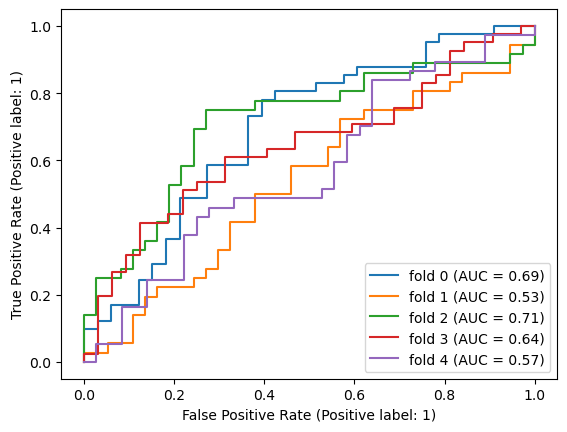

accuracy:0.5900777489818585, specificity: 0.5323778323778324, sensitivity:0.6442723211015895, balanced_score: 0.5883250767397109


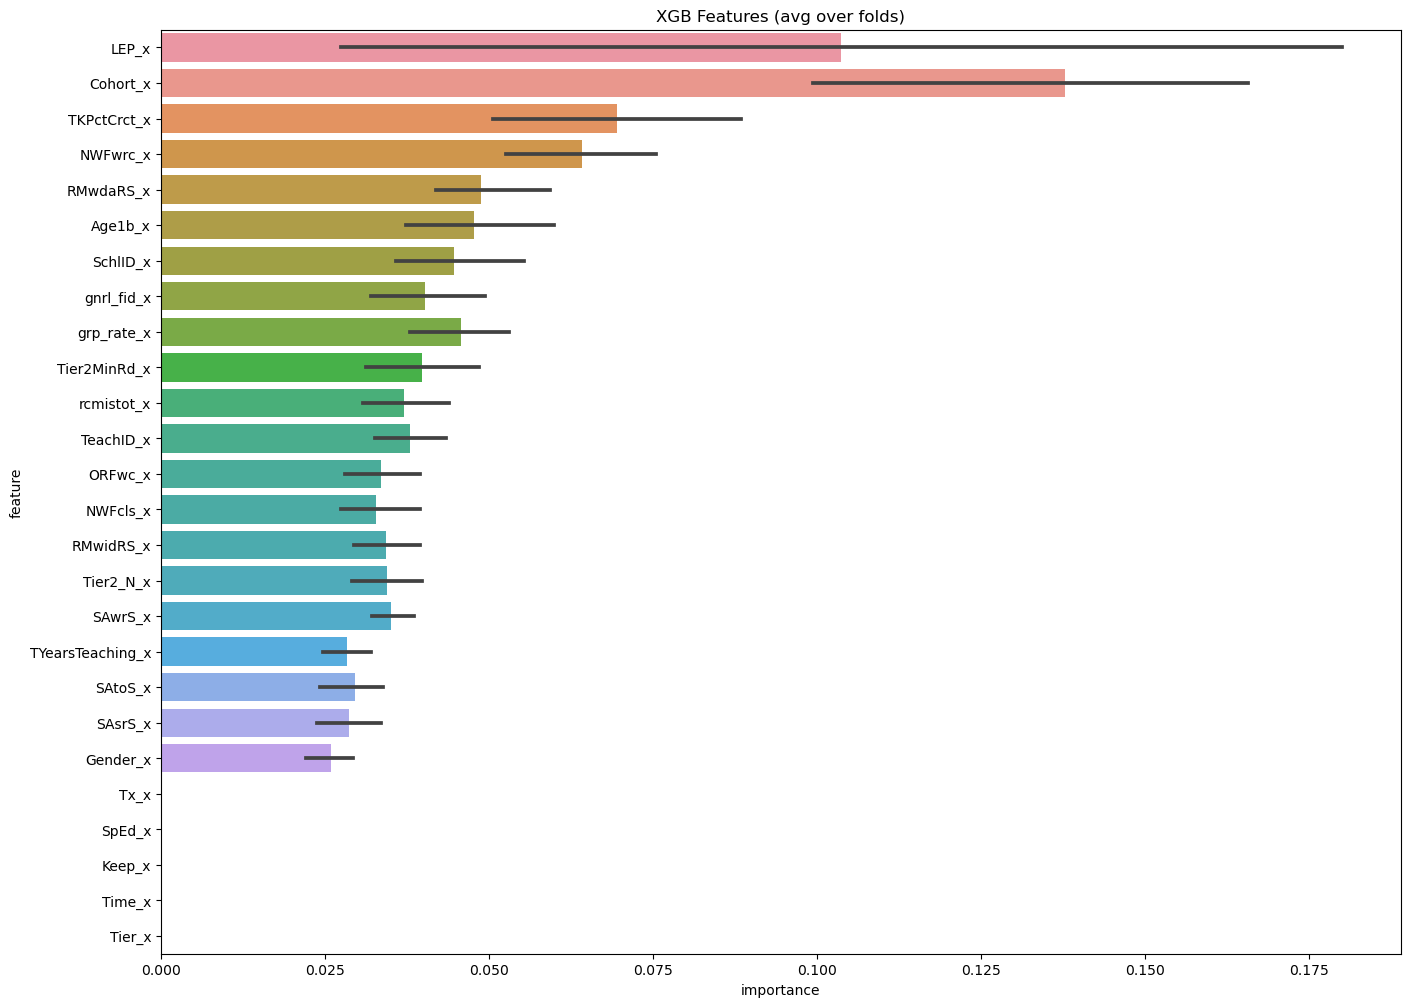

In [13]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_ctrl[feature_columns], data_ctrl[target], groups=data_ctrl.StuID)):
    X_train, y_train = data_ctrl[feature_columns].iloc[train_idx], data_ctrl[target].iloc[train_idx]
    X_valid, y_valid = data_ctrl[feature_columns].iloc[val_idx], data_ctrl[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

fold 0 training, target :RMwidRS_target
[07:15:49] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.72850	validation_1-auc:0.65919
[1000]	validation_0-auc:0.99765	validation_1-auc:0.70147
[2000]	validation_0-auc:0.99944	validation_1-auc:0.70074
[2066]	validation_0-auc:0.99944	validation_1-auc:0.70221
accuracy:0.6216216216216216, specificity: 0.7058823529411765, sensitivity:0.55, balanced_score: 0.6279411764705882
fold 1 training, target :RMwidRS_target
[07:15:51] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.68961	validation_1-auc:0.58411
[1000]	validation_0-auc:0.99688	valida

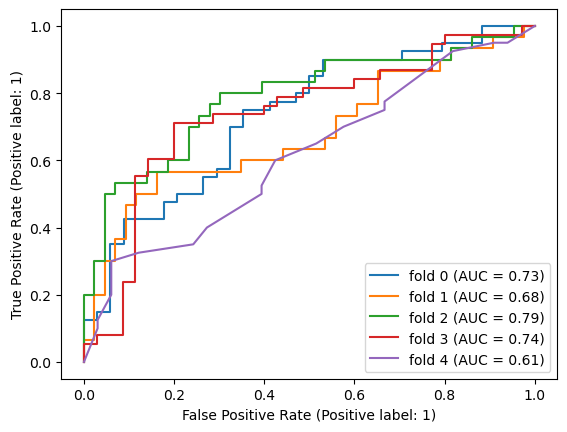

accuracy:0.6530914476119956, specificity: 0.7093270796690769, sensitivity:0.5940350877192982, balanced_score: 0.6516810836941875


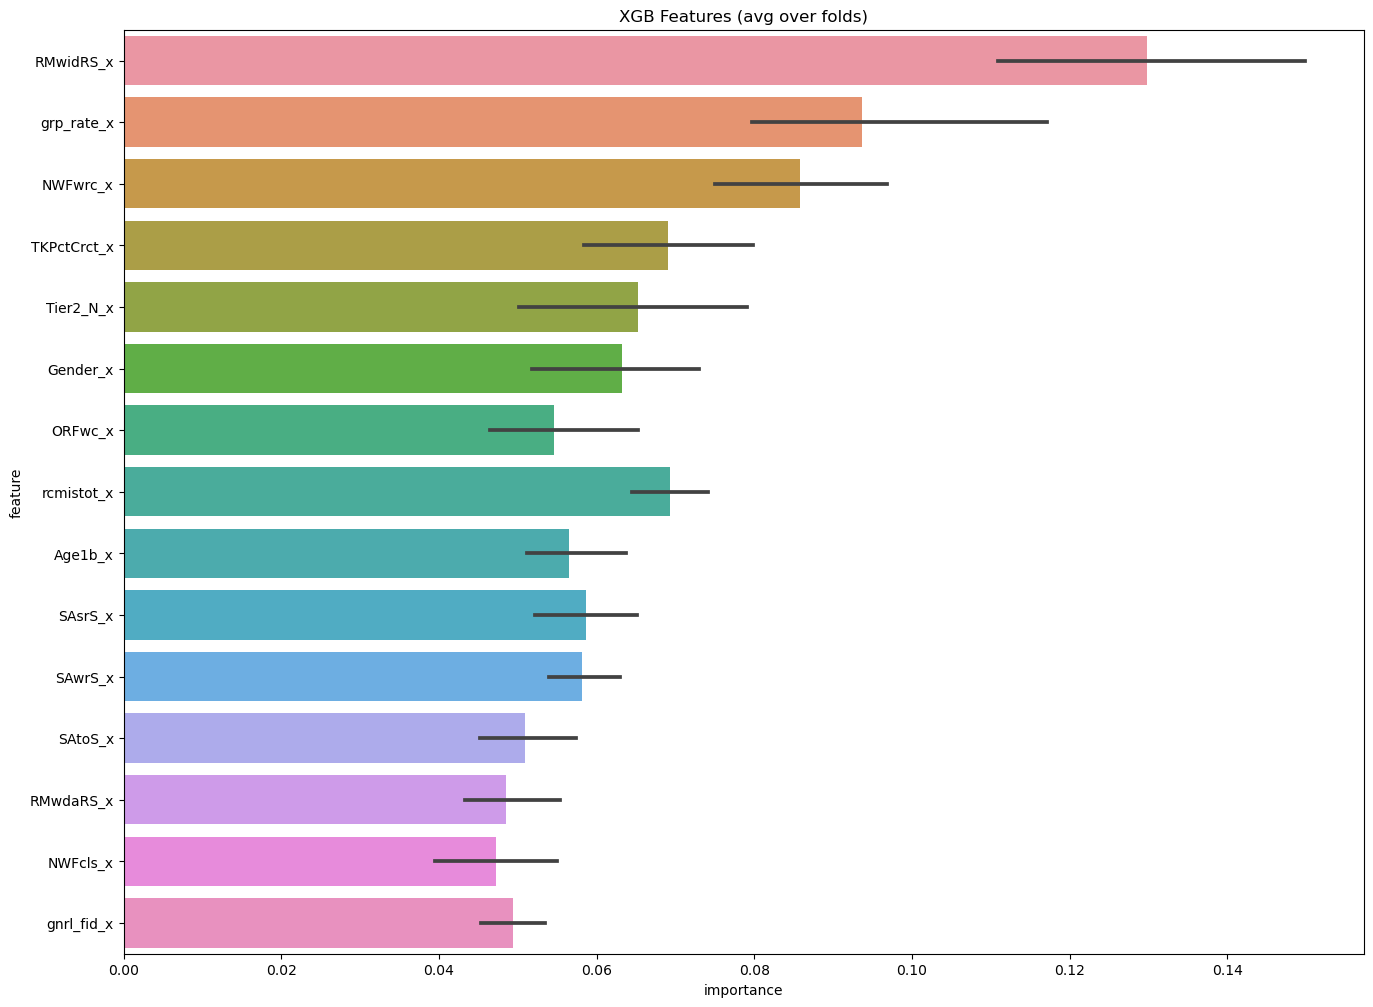

In [14]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_ctrl[feature_columns_noTx], data_ctrl[target], groups=data_ctrl.StuID)):
    X_train, y_train = data_ctrl[feature_columns_noTx].iloc[train_idx], data_ctrl[target].iloc[train_idx]
    X_valid, y_valid = data_ctrl[feature_columns_noTx].iloc[val_idx], data_ctrl[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns_noTx
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[07:16:00] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.67350	validation_1-auc:0.51404
[1000]	validation_0-auc:0.99653	validation_1-auc:0.66519
[2000]	validation_0-auc:0.99826	validation_1-auc:0.67110
[2003]	validation_0-auc:0.99826	validation_1-auc:0.66962
accuracy:0.6351351351351351, specificity: 0.5454545454545454, sensitivity:0.7073170731707317, balanced_score: 0.6263858093126385
fold 1 training, target :RMwdaRS_target
[07:16:01] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.68034	validation_1-auc:0.43769
[1000]	validation_0-auc:

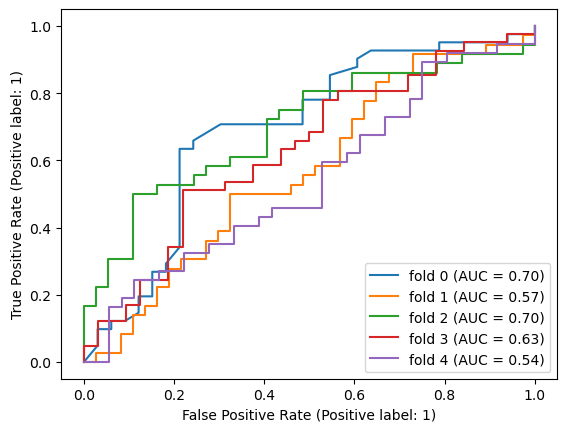

accuracy:0.5873009996297668, specificity: 0.5040796478296479, sensitivity:0.664989379623526, balanced_score: 0.5845345137265868


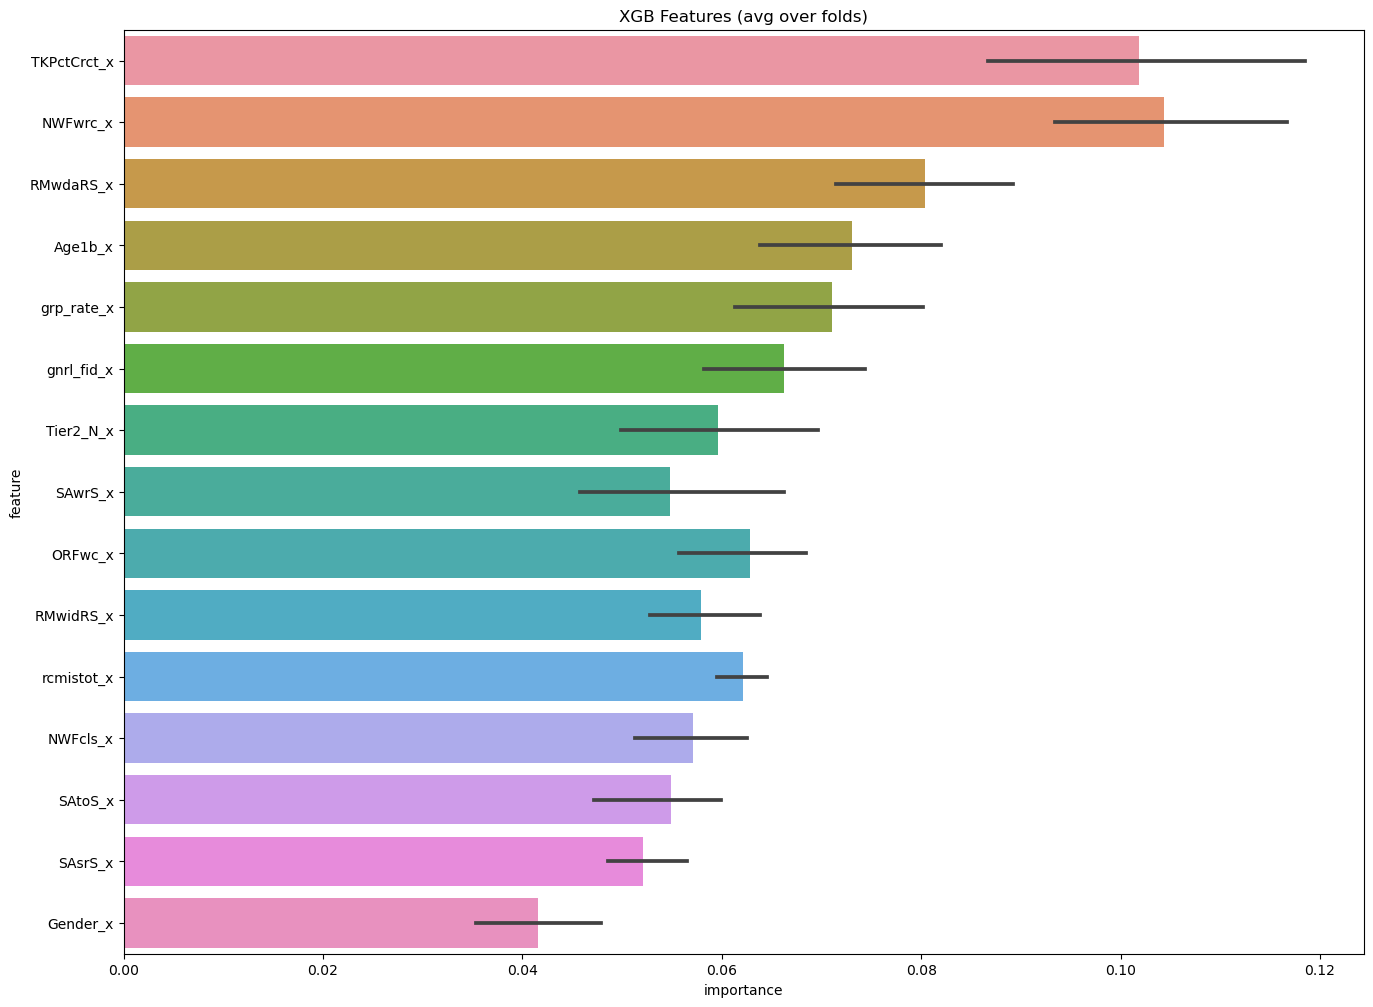

In [15]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_ctrl[feature_columns_noTx], data_ctrl[target], groups=data_ctrl.StuID)):
    X_train, y_train = data_ctrl[feature_columns_noTx].iloc[train_idx], data_ctrl[target].iloc[train_idx]
    X_valid, y_valid = data_ctrl[feature_columns_noTx].iloc[val_idx], data_ctrl[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns_noTx
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

### Intervention group

fold 0 training, target :RMwidRS_target
[07:16:09] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.72050	validation_1-auc:0.68835
[1000]	validation_0-auc:0.99200	validation_1-auc:0.68887
[2000]	validation_0-auc:0.99623	validation_1-auc:0.67742
[2009]	validation_0-auc:0.99636	validation_1-auc:0.67742
accuracy:0.6290322580645161, specificity: 0.3870967741935484, sensitivity:0.8709677419354839, balanced_score: 0.6290322580645161
fold 1 training, target :RMwidRS_target
[07:16:11] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.73052	validation_1-auc:0.72448
[1000]	validation_0-auc:

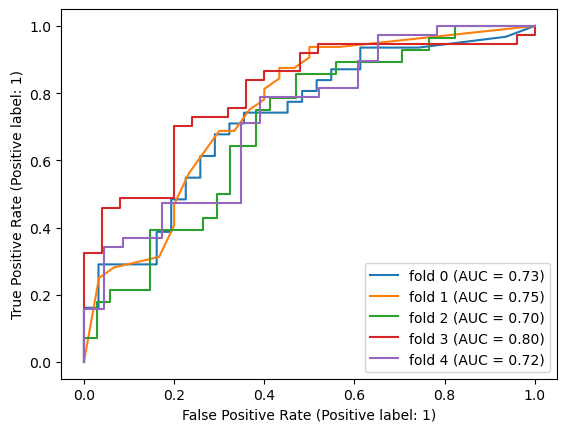

accuracy:0.6795875198307774, specificity: 0.5791482550944641, sensitivity:0.7730530281676292, balanced_score: 0.6761006416310467


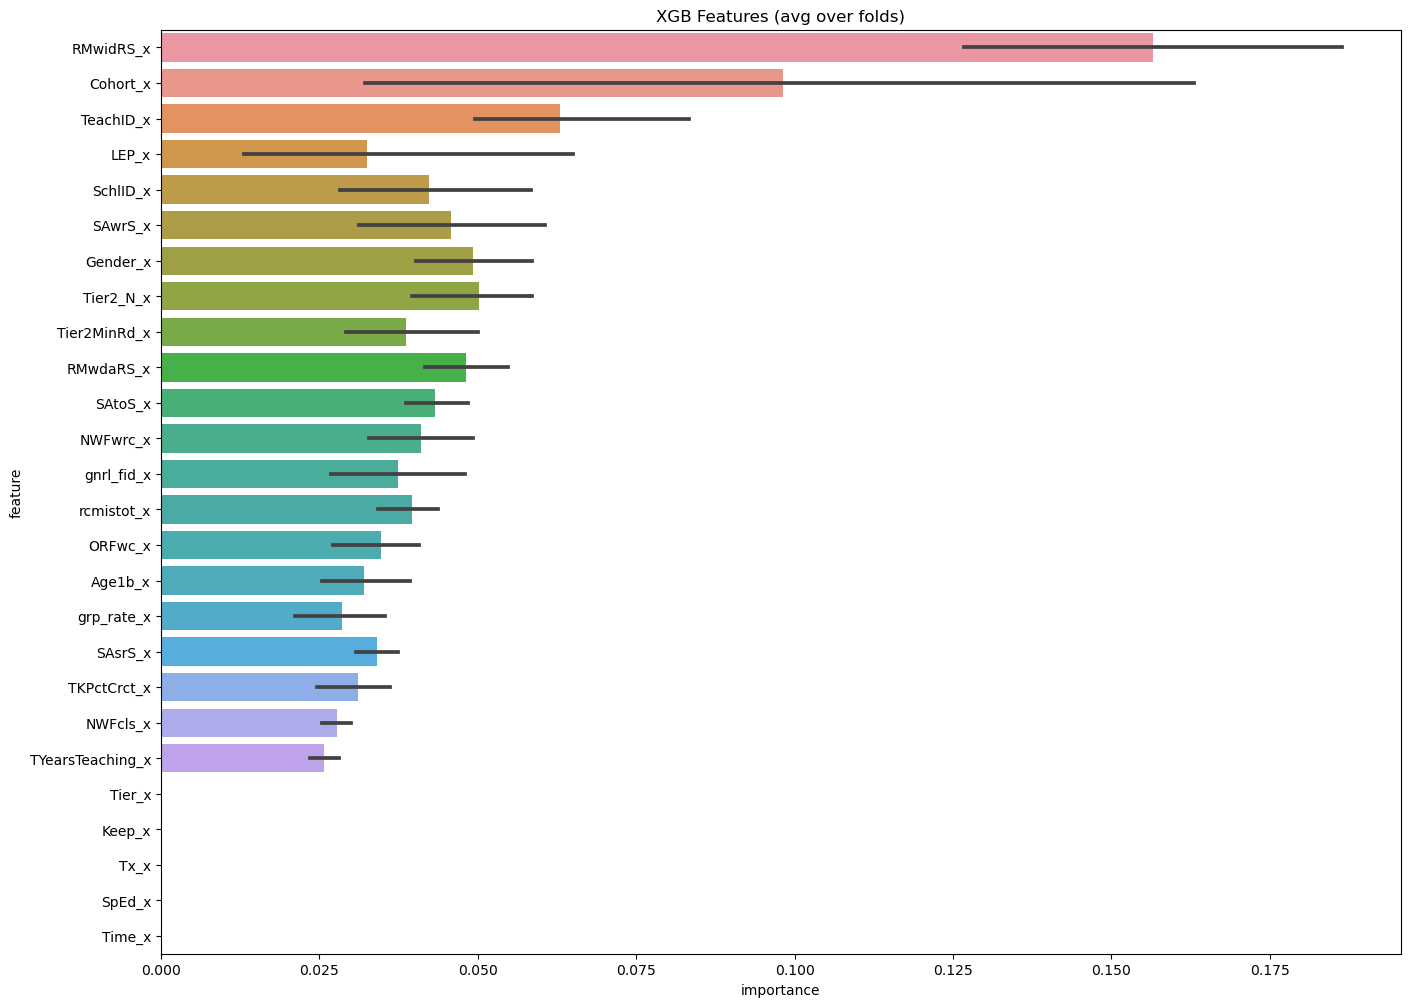

In [16]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_intn[feature_columns], data_intn[target], groups=data_intn.StuID)):
    X_train, y_train = data_intn[feature_columns].iloc[train_idx], data_intn[target].iloc[train_idx]
    X_valid, y_valid = data_intn[feature_columns].iloc[val_idx], data_intn[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[07:16:22] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.62452	validation_1-auc:0.62974
[1000]	validation_0-auc:0.99427	validation_1-auc:0.72950
[2000]	validation_0-auc:0.99787	validation_1-auc:0.72338
[3000]	validation_0-auc:0.99846	validation_1-auc:0.71971
[3379]	validation_0-auc:0.99860	validation_1-auc:0.71848
accuracy:0.7258064516129032, specificity: 0.2631578947368421, sensitivity:0.9302325581395349, balanced_score: 0.5966952264381885
fold 1 training, target :RMwdaRS_target
[07:16:25] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:

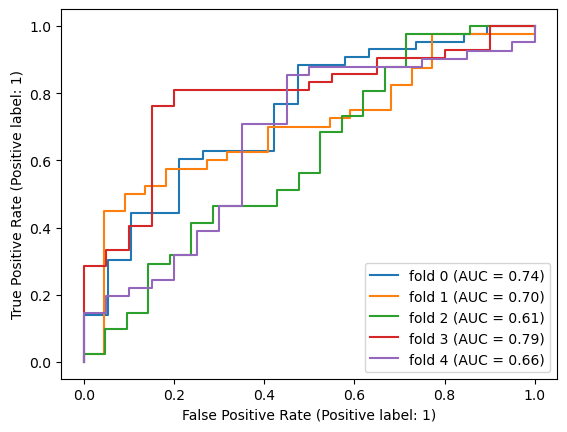

accuracy:0.67625594923321, specificity: 0.2920255183413078, sensitivity:0.8636887880506713, balanced_score: 0.5778571531959895


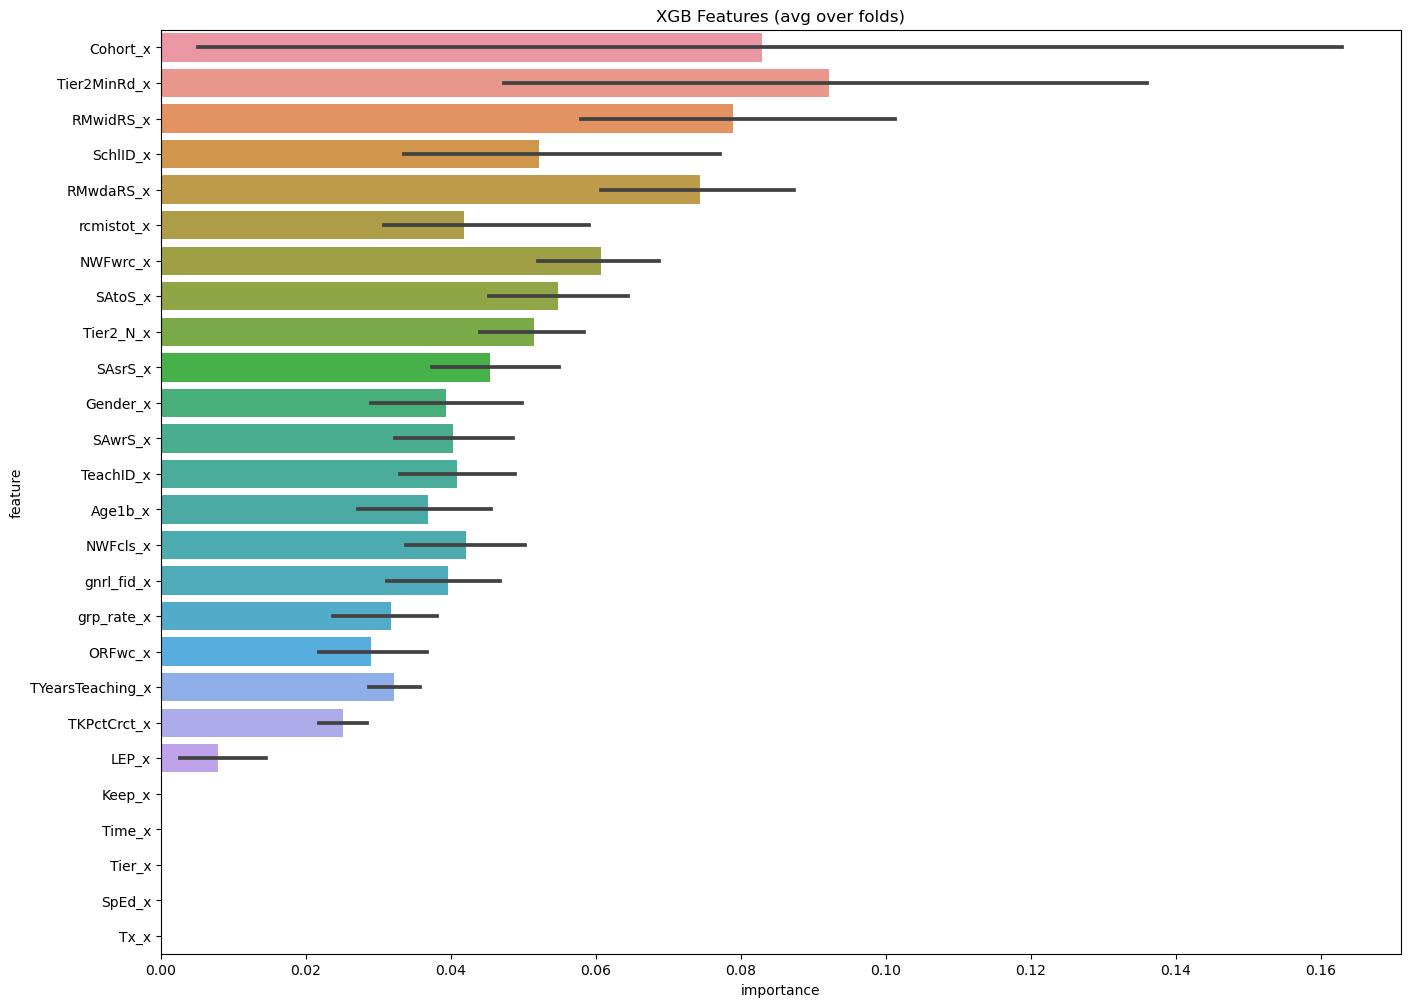

In [17]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_intn[feature_columns], data_intn[target], groups=data_intn.StuID)):
    X_train, y_train = data_intn[feature_columns].iloc[train_idx], data_intn[target].iloc[train_idx]
    X_valid, y_valid = data_intn[feature_columns].iloc[val_idx], data_intn[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

fold 0 training, target :RMwidRS_target
[07:16:39] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.72050	validation_1-auc:0.68835
[1000]	validation_0-auc:0.98856	validation_1-auc:0.68574
[2000]	validation_0-auc:0.99392	validation_1-auc:0.67950
[2264]	validation_0-auc:0.99451	validation_1-auc:0.67846
accuracy:0.6935483870967742, specificity: 0.5161290322580645, sensitivity:0.8709677419354839, balanced_score: 0.6935483870967742
fold 1 training, target :RMwidRS_target
[07:16:41] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.71166	validation_1-auc:0.71719
[1000]	validation_0-auc:

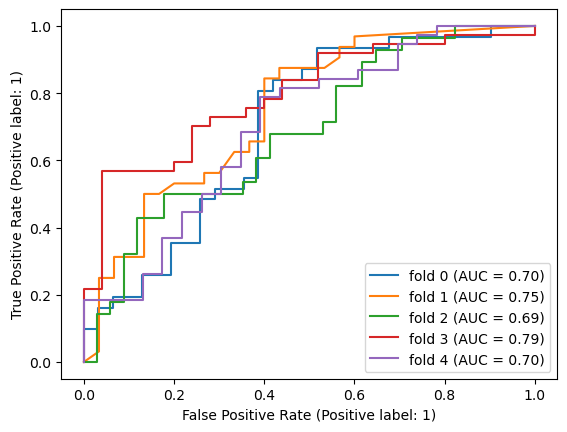

accuracy:0.6699101004759387, specificity: 0.5462096086681518, sensitivity:0.7856012907158918, balanced_score: 0.6659054496920217


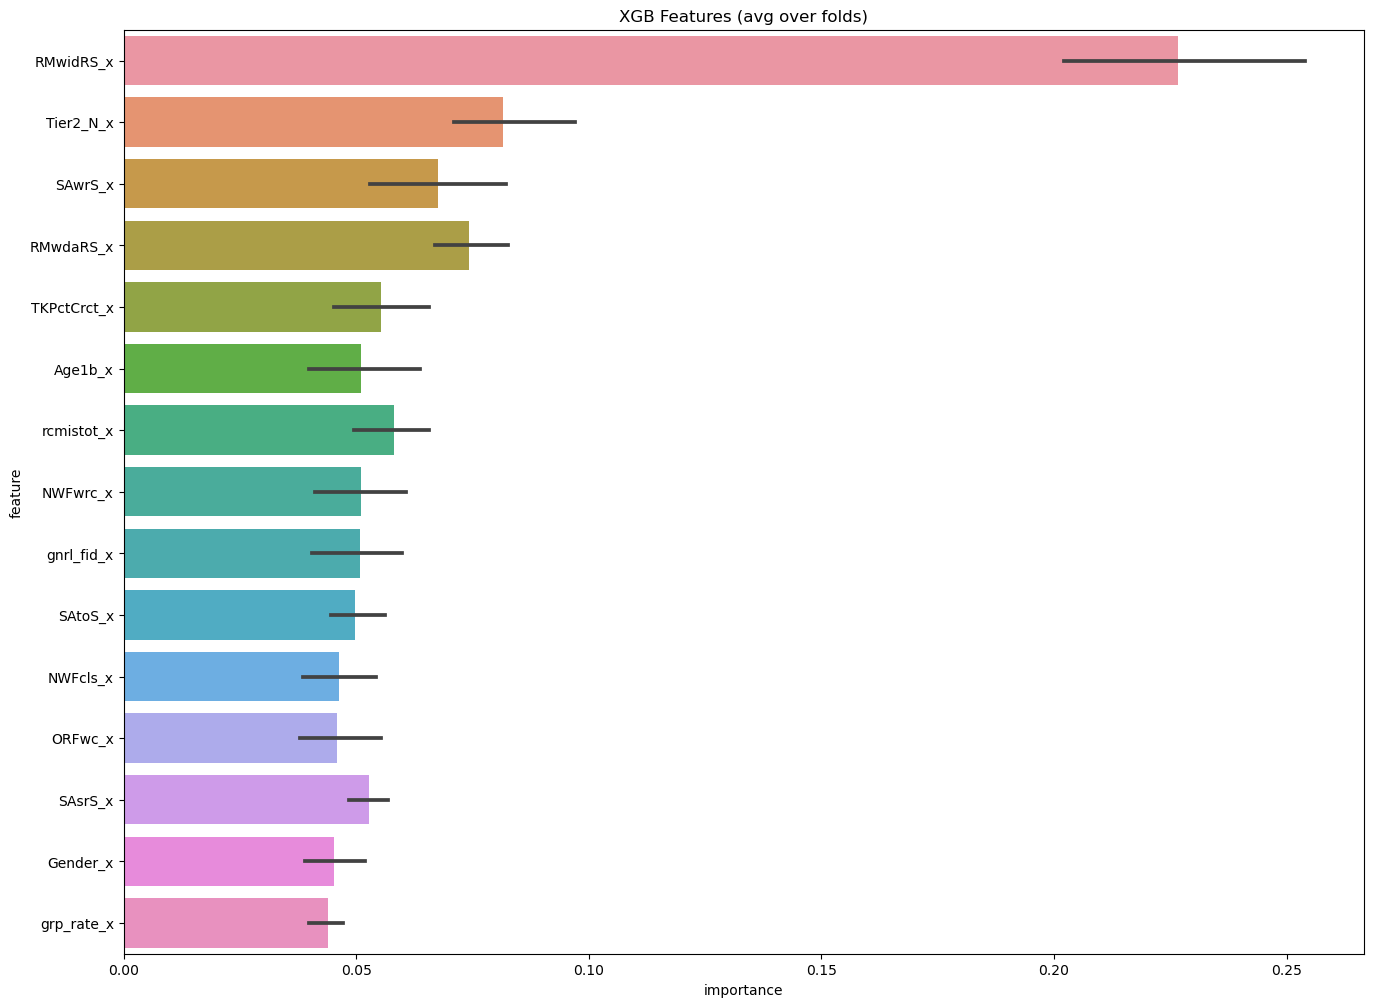

In [18]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_intn[feature_columns_noTx], data_intn[target], groups=data_intn.StuID)):
    X_train, y_train = data_intn[feature_columns_noTx].iloc[train_idx], data_intn[target].iloc[train_idx]
    X_valid, y_valid = data_intn[feature_columns_noTx].iloc[val_idx], data_intn[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns_noTx
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[07:16:48] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.64770	validation_1-auc:0.51285
[1000]	validation_0-auc:0.99185	validation_1-auc:0.76377
[2000]	validation_0-auc:0.99699	validation_1-auc:0.76744
[3000]	validation_0-auc:0.99809	validation_1-auc:0.77479
[4000]	validation_0-auc:0.99853	validation_1-auc:0.77111
[4889]	validation_0-auc:0.99875	validation_1-auc:0.77111
accuracy:0.7258064516129032, specificity: 0.3157894736842105, sensitivity:0.9069767441860465, balanced_score: 0.6113831089351285
fold 1 training, target :RMwdaRS_target
[07:16:52] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves"

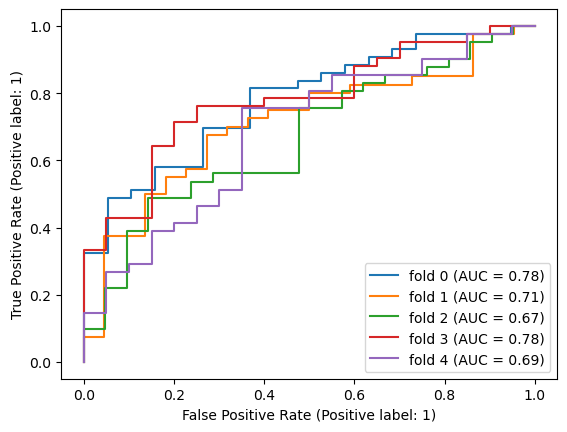

accuracy:0.6731887890005288, specificity: 0.3248462064251538, sensitivity:0.8450016206142127, balanced_score: 0.5849239135196832


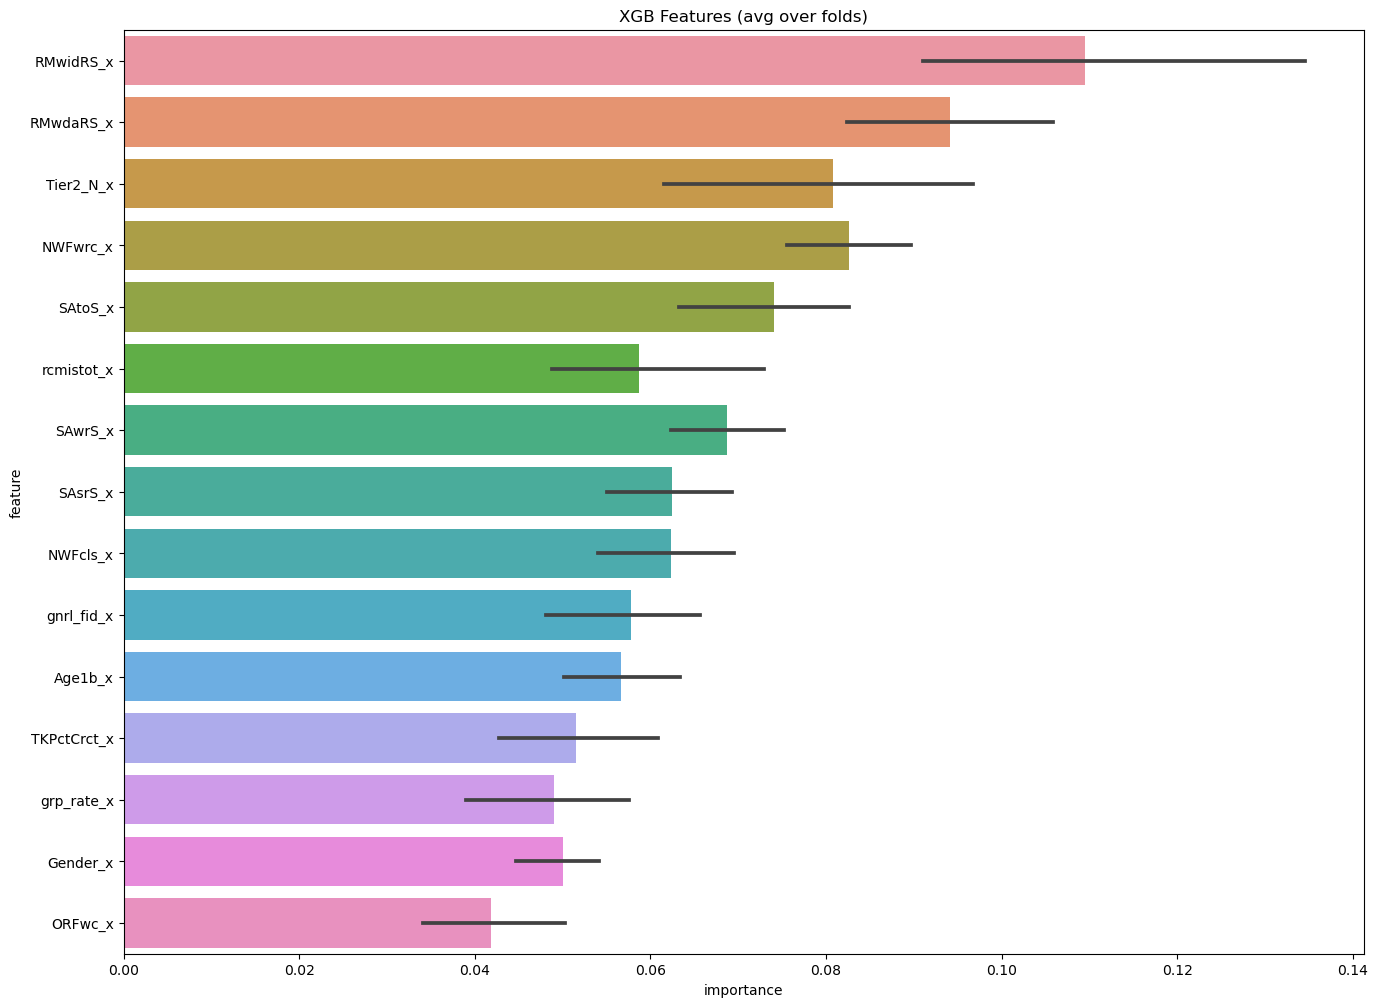

In [19]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_intn[feature_columns_noTx], data_intn[target], groups=data_intn.StuID)):
    X_train, y_train = data_intn[feature_columns_noTx].iloc[train_idx], data_intn[target].iloc[train_idx]
    X_valid, y_valid = data_intn[feature_columns_noTx].iloc[val_idx], data_intn[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_columns_noTx
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

### Only selected features

fold 0 training, target :RMwidRS_target
[07:17:03] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.67972	validation_1-auc:0.74528
[1000]	validation_0-auc:0.98713	validation_1-auc:0.67523
[2000]	validation_0-auc:0.99452	validation_1-auc:0.67040
[2001]	validation_0-auc:0.99452	validation_1-auc:0.67040
accuracy:0.7185185185185186, specificity: 0.7424242424242424, sensitivity:0.6956521739130435, balanced_score: 0.719038208168643
fold 1 training, target :RMwidRS_target
[07:17:04] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.69206	validation_1-auc:0.61836
[1000]	validation_0-auc:0

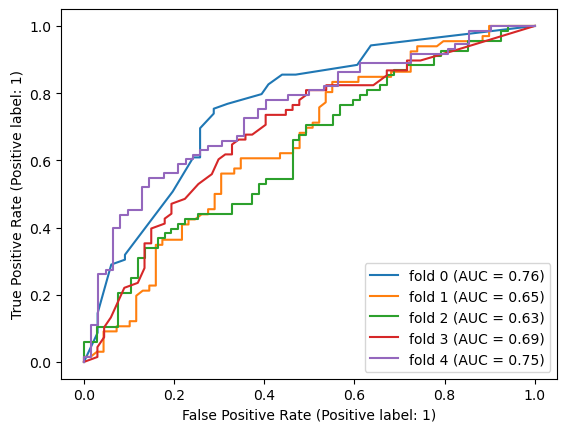

accuracy:0.6474074074074074, specificity: 0.6116291550027497, sensitivity:0.6823983272446993, balanced_score: 0.6470137411237247


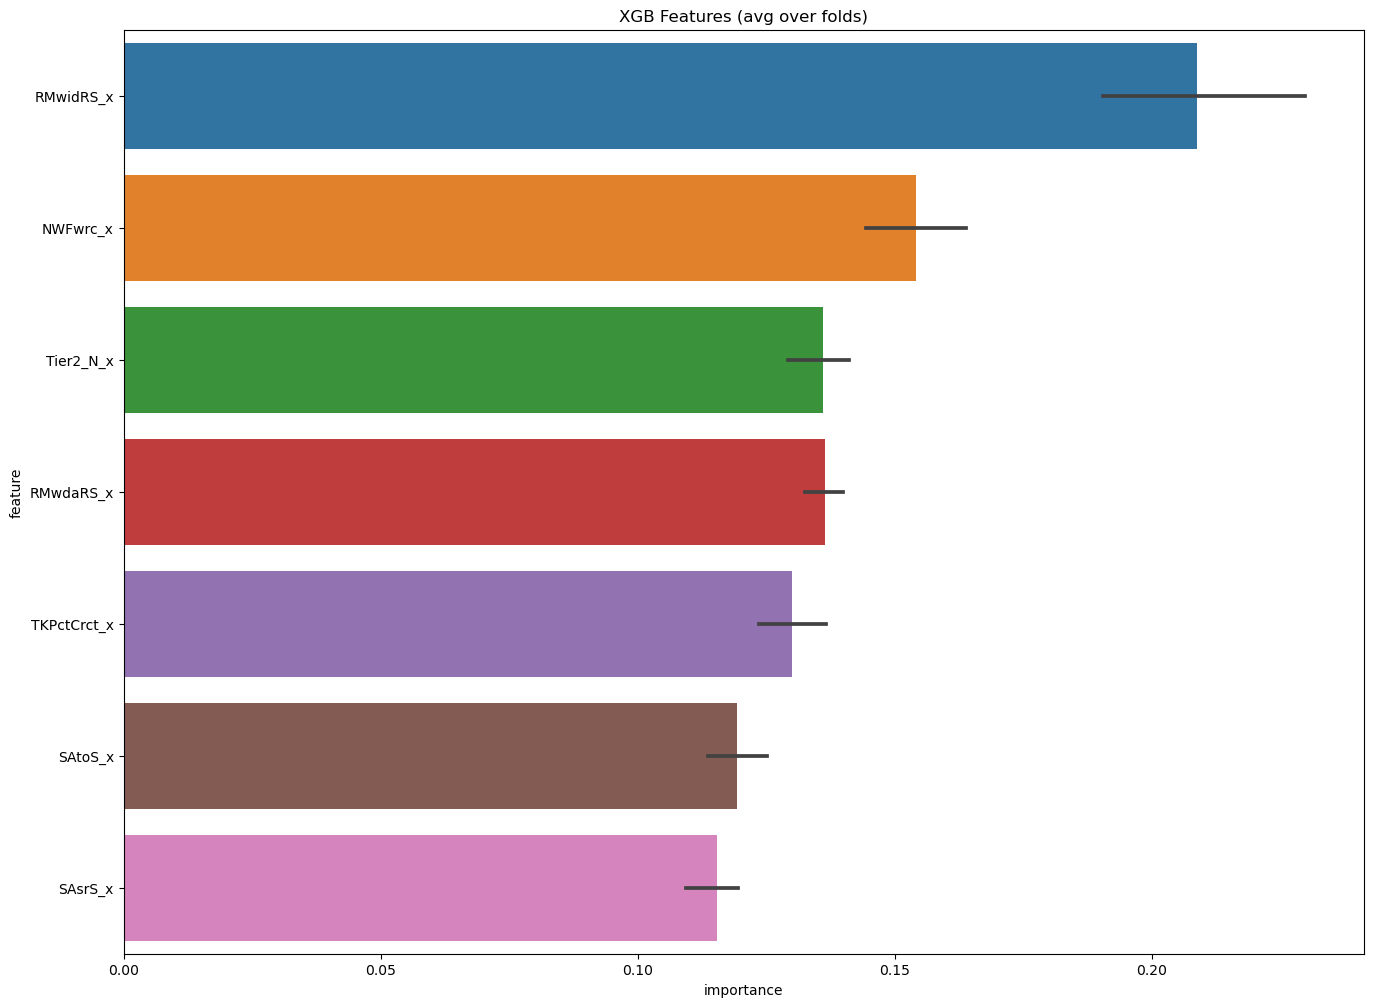

In [20]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[selected_features_wid], data_merged[target], groups=data_merged.StuID)):
    X_train, y_train = data_merged[selected_features_wid].iloc[train_idx], data_merged[target].iloc[train_idx]
    X_valid, y_valid = data_merged[selected_features_wid].iloc[val_idx], data_merged[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = selected_features_wid
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

fold 0 training, target :RMwidRS_target
[07:17:12] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.66478	validation_1-auc:0.57904
[1000]	validation_0-auc:0.96523	validation_1-auc:0.61397
[2000]	validation_0-auc:0.98028	validation_1-auc:0.61544
[2300]	validation_0-auc:0.98146	validation_1-auc:0.61912
accuracy:0.581081081081081, specificity: 0.6470588235294118, sensitivity:0.525, balanced_score: 0.5860294117647059
fold 1 training, target :RMwidRS_target
[07:17:13] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.68733	validation_1-auc:0.73062
[1000]	validation_0-auc:0.96918	valida

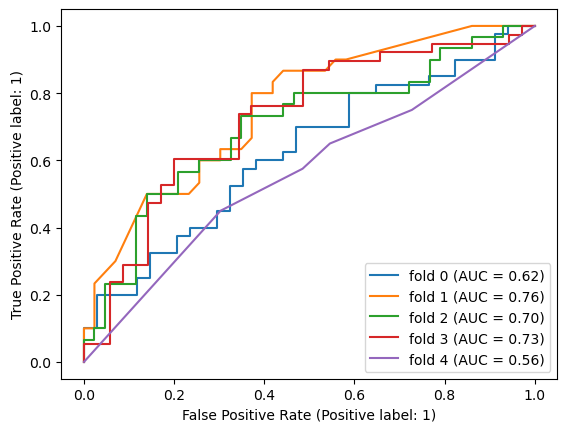

accuracy:0.6175860792299148, specificity: 0.6243357554438267, sensitivity:0.611578947368421, balanced_score: 0.6179573514061237


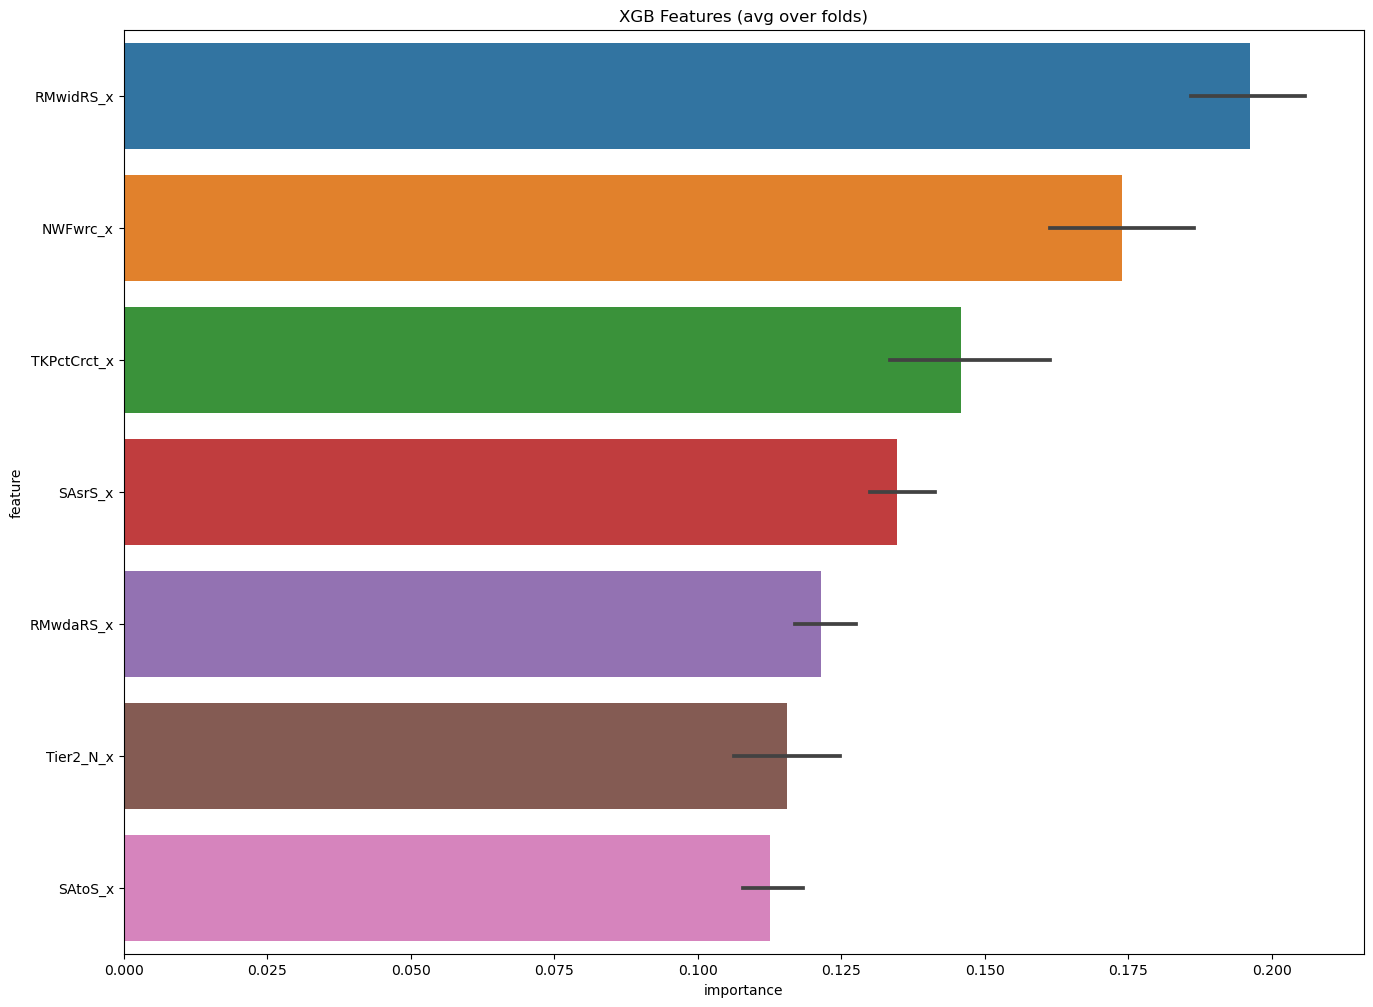

In [21]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_ctrl[selected_features_wid], data_ctrl[target], groups=data_ctrl.StuID)):
    X_train, y_train = data_ctrl[selected_features_wid].iloc[train_idx], data_ctrl[target].iloc[train_idx]
    X_valid, y_valid = data_ctrl[selected_features_wid].iloc[val_idx], data_ctrl[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = selected_features_wid
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

fold 0 training, target :RMwidRS_target
[07:17:19] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.72050	validation_1-auc:0.68835
[1000]	validation_0-auc:0.94345	validation_1-auc:0.75546
[2000]	validation_0-auc:0.95807	validation_1-auc:0.75234
[2130]	validation_0-auc:0.95847	validation_1-auc:0.75338
accuracy:0.6612903225806451, specificity: 0.5161290322580645, sensitivity:0.8064516129032258, balanced_score: 0.6612903225806451
fold 1 training, target :RMwidRS_target
[07:17:21] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.71166	validation_1-auc:0.71719
[1000]	validation_0-auc:

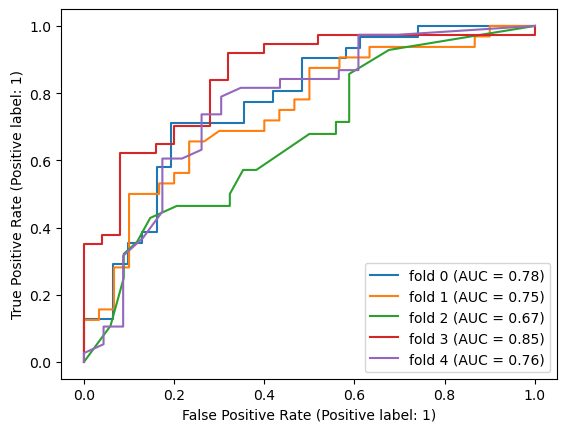

accuracy:0.6797461660497092, specificity: 0.5078396171933008, sensitivity:0.8264612736068593, balanced_score: 0.6671504454000802


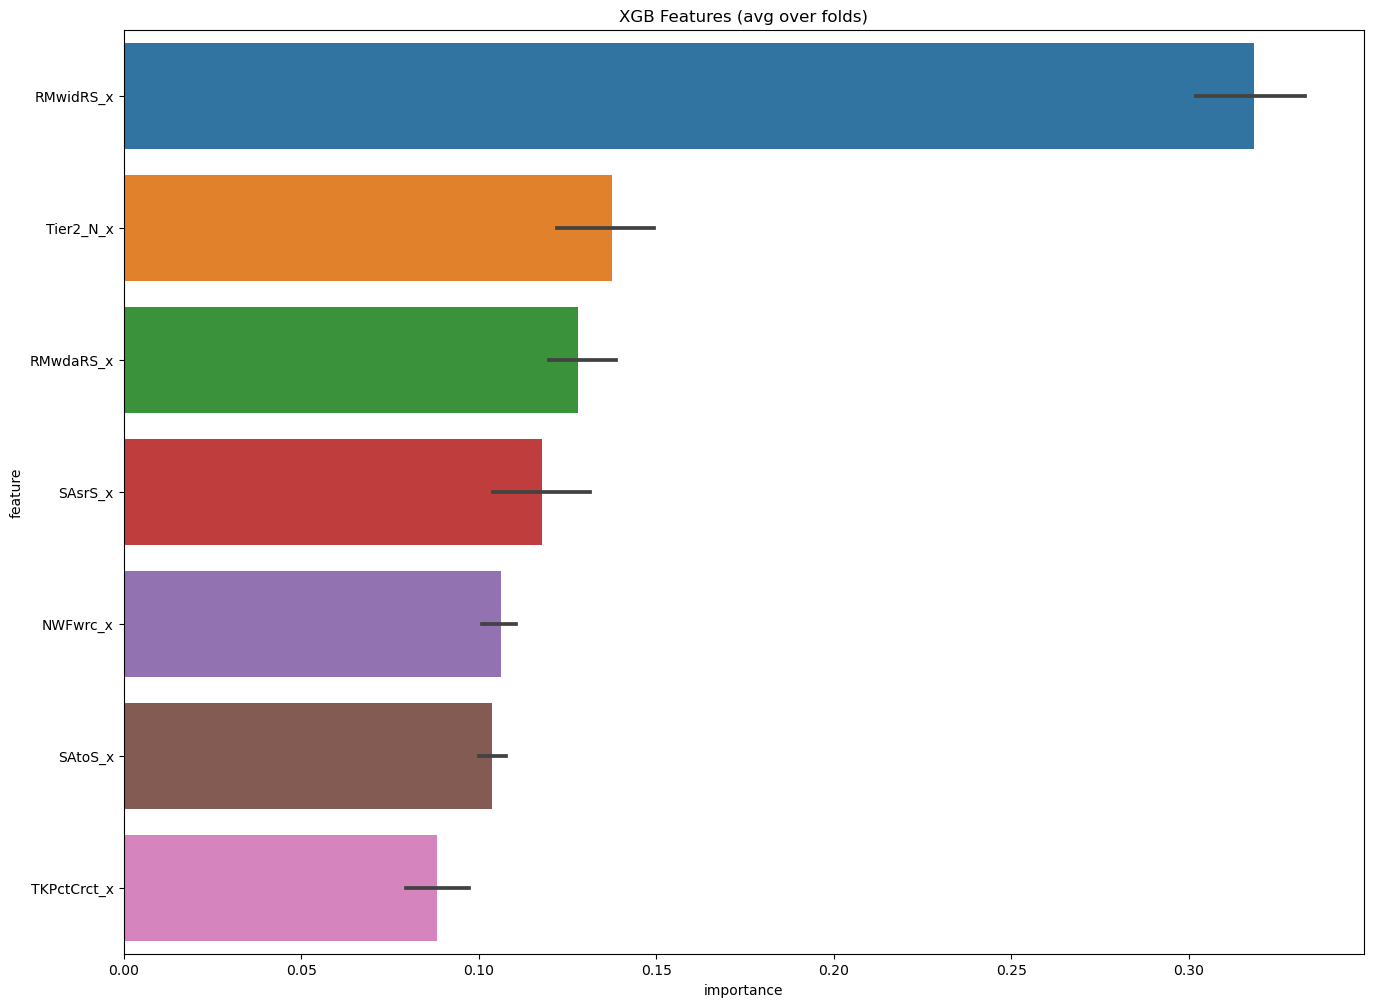

In [22]:
gkf = GroupKFold(n_splits = 5)

target = "RMwidRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_intn[selected_features_wid], data_intn[target], groups=data_intn.StuID)):
    X_train, y_train = data_intn[selected_features_wid].iloc[train_idx], data_intn[target].iloc[train_idx]
    X_valid, y_valid = data_intn[selected_features_wid].iloc[val_idx], data_intn[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = selected_features_wid
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[07:17:26] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.65754	validation_1-auc:0.50012
[1000]	validation_0-auc:0.96359	validation_1-auc:0.48599
[2000]	validation_0-auc:0.97788	validation_1-auc:0.48786
[2002]	validation_0-auc:0.97797	validation_1-auc:0.48810
accuracy:0.5703703703703704, specificity: 0.27450980392156865, sensitivity:0.75, balanced_score: 0.5122549019607843
fold 1 training, target :RMwdaRS_target
[07:17:28] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.65567	validation_1-auc:0.69383
[1000]	validation_0-auc:0.96591	valid

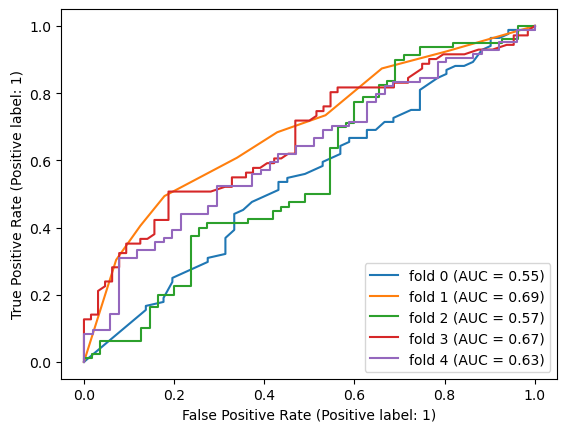

accuracy:0.6029629629629629, specificity: 0.3705724789915966, sensitivity:0.7689355542537928, balanced_score: 0.5697540166226946


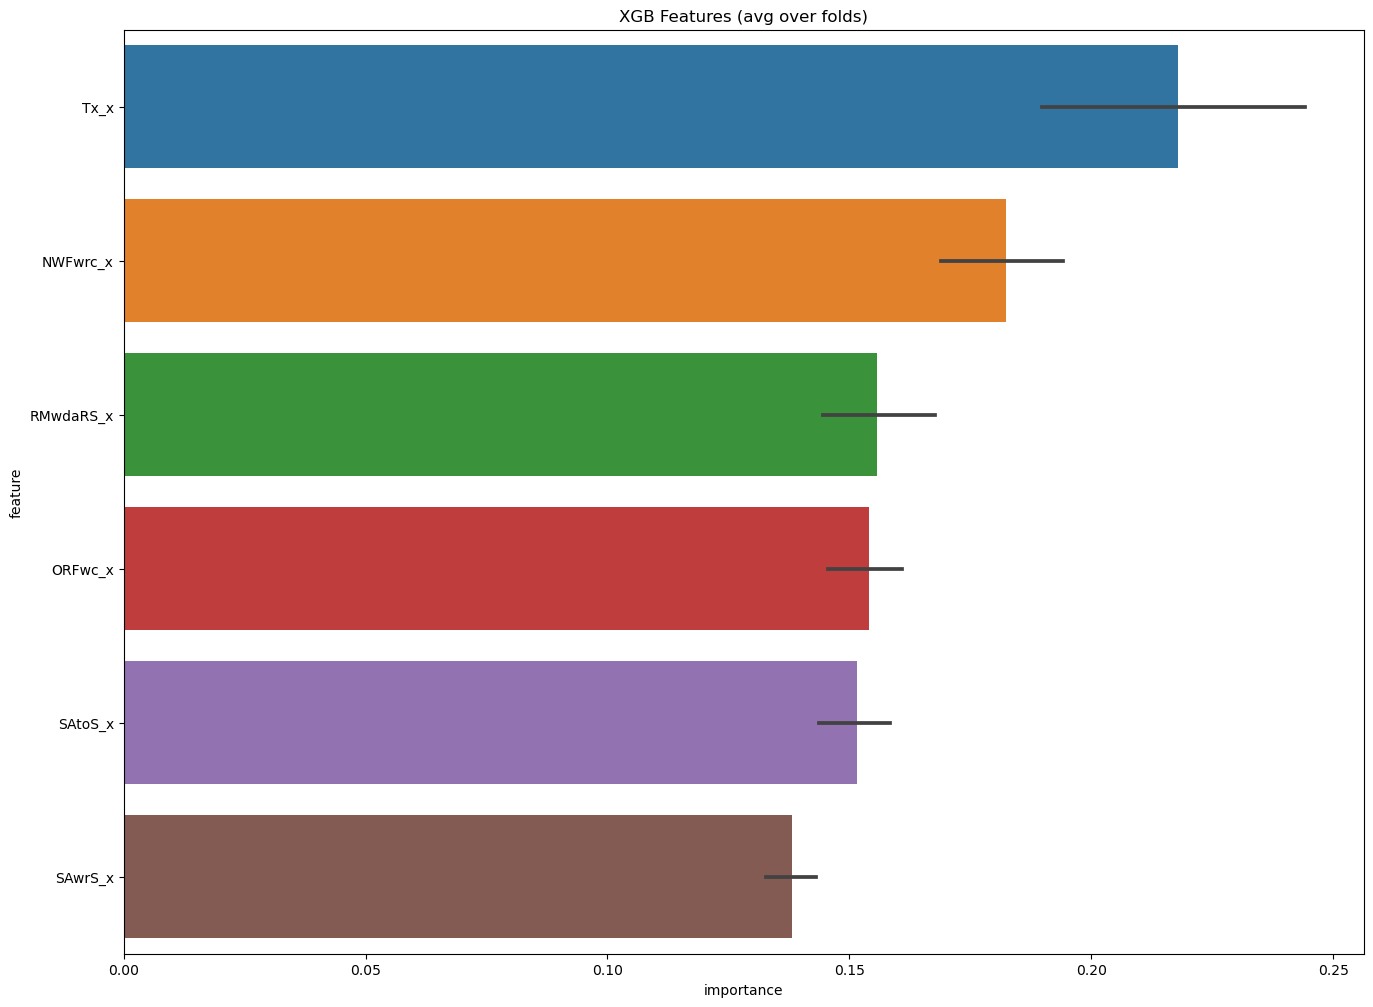

In [23]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_merged[selected_features_wda], data_merged[target], groups=data_merged.StuID)):
    X_train, y_train = data_merged[selected_features_wda].iloc[train_idx], data_merged[target].iloc[train_idx]
    X_valid, y_valid = data_merged[selected_features_wda].iloc[val_idx], data_merged[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = selected_features_wda
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[07:17:36] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.62256	validation_1-auc:0.64634
[1000]	validation_0-auc:0.93967	validation_1-auc:0.54250
[2000]	validation_0-auc:0.95568	validation_1-auc:0.52993
accuracy:0.581081081081081, specificity: 0.696969696969697, sensitivity:0.4878048780487805, balanced_score: 0.5923872875092387
fold 1 training, target :RMwdaRS_target
[07:17:37] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.61741	validation_1-auc:0.65390
[1000]	validation_0-auc:0.91335	validation_1-auc:0.66441
[2000]	validation_0-auc:0.

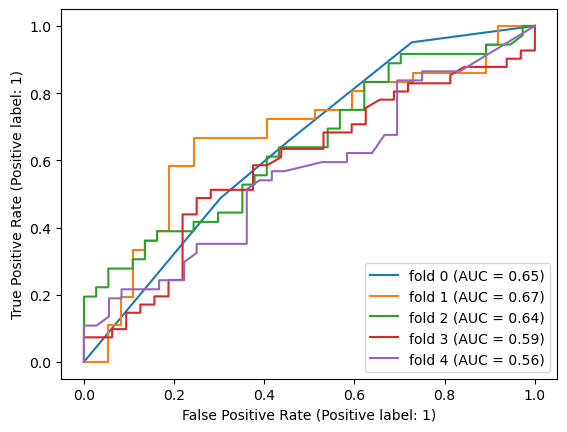

accuracy:0.5655312847093669, specificity: 0.49425505050505053, sensitivity:0.6366256500402843, balanced_score: 0.5654403502726673


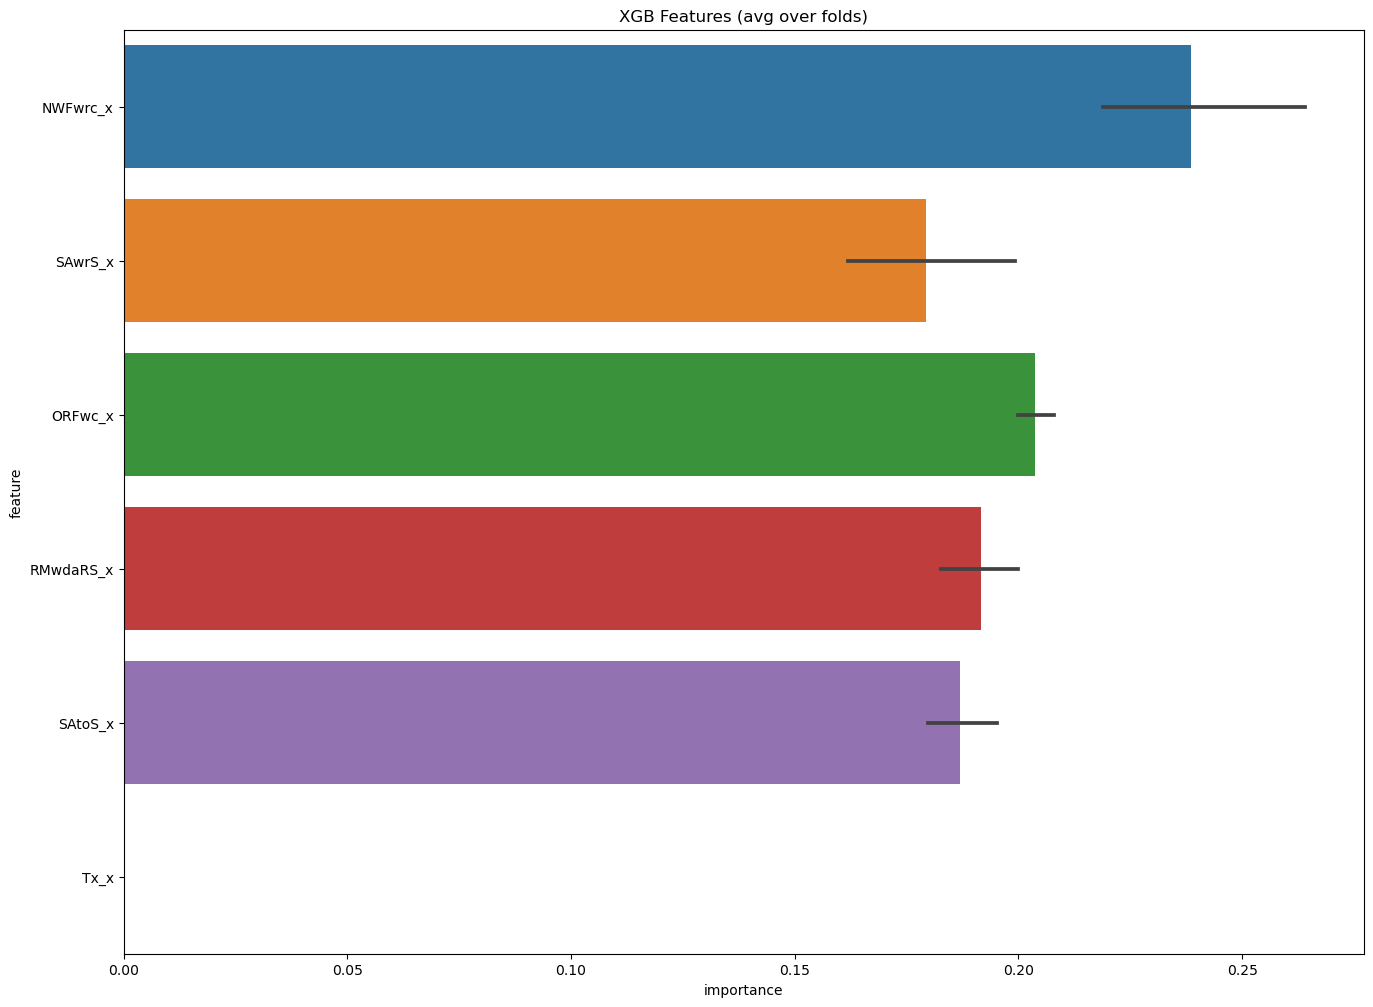

In [24]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_ctrl[selected_features_wda], data_ctrl[target], groups=data_ctrl.StuID)):
    X_train, y_train = data_ctrl[selected_features_wda].iloc[train_idx], data_ctrl[target].iloc[train_idx]
    X_valid, y_valid = data_ctrl[selected_features_wda].iloc[val_idx], data_ctrl[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = selected_features_wda
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');

fold 0 training, target :RMwdaRS_target
[07:17:43] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.58614	validation_1-auc:0.45716
[1000]	validation_0-auc:0.88984	validation_1-auc:0.56181
[2000]	validation_0-auc:0.90681	validation_1-auc:0.56671
[2047]	validation_0-auc:0.90754	validation_1-auc:0.56548
accuracy:0.7096774193548387, specificity: 0.10526315789473684, sensitivity:0.9767441860465116, balanced_score: 0.5410036719706242
fold 1 training, target :RMwdaRS_target
[07:17:44] WARNING: ../src/learner.cc:767: 
Parameters: { "boosting_type", "feature_fraction", "feature_fraction_seed", "is_unbalance", "max_bins", "metric", "min_data_in_leaf", "min_split_gain", "num_leaves", "subsample_freq" } are not used.

[0]	validation_0-auc:0.61609	validation_1-auc:0.59545
[1000]	validation_0-auc

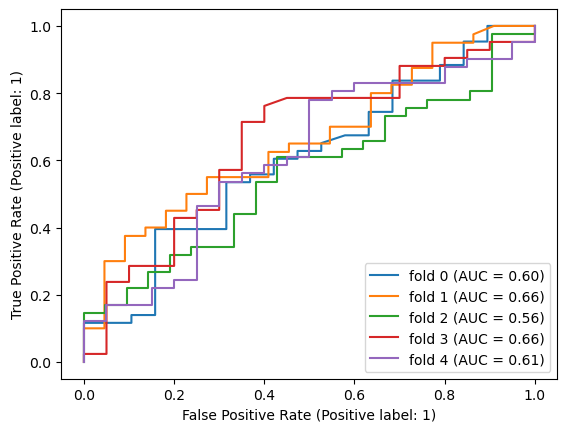

accuracy:0.6601269169751454, specificity: 0.12555479608111186, sensitivity:0.9221664911001269, balanced_score: 0.5238606435906195


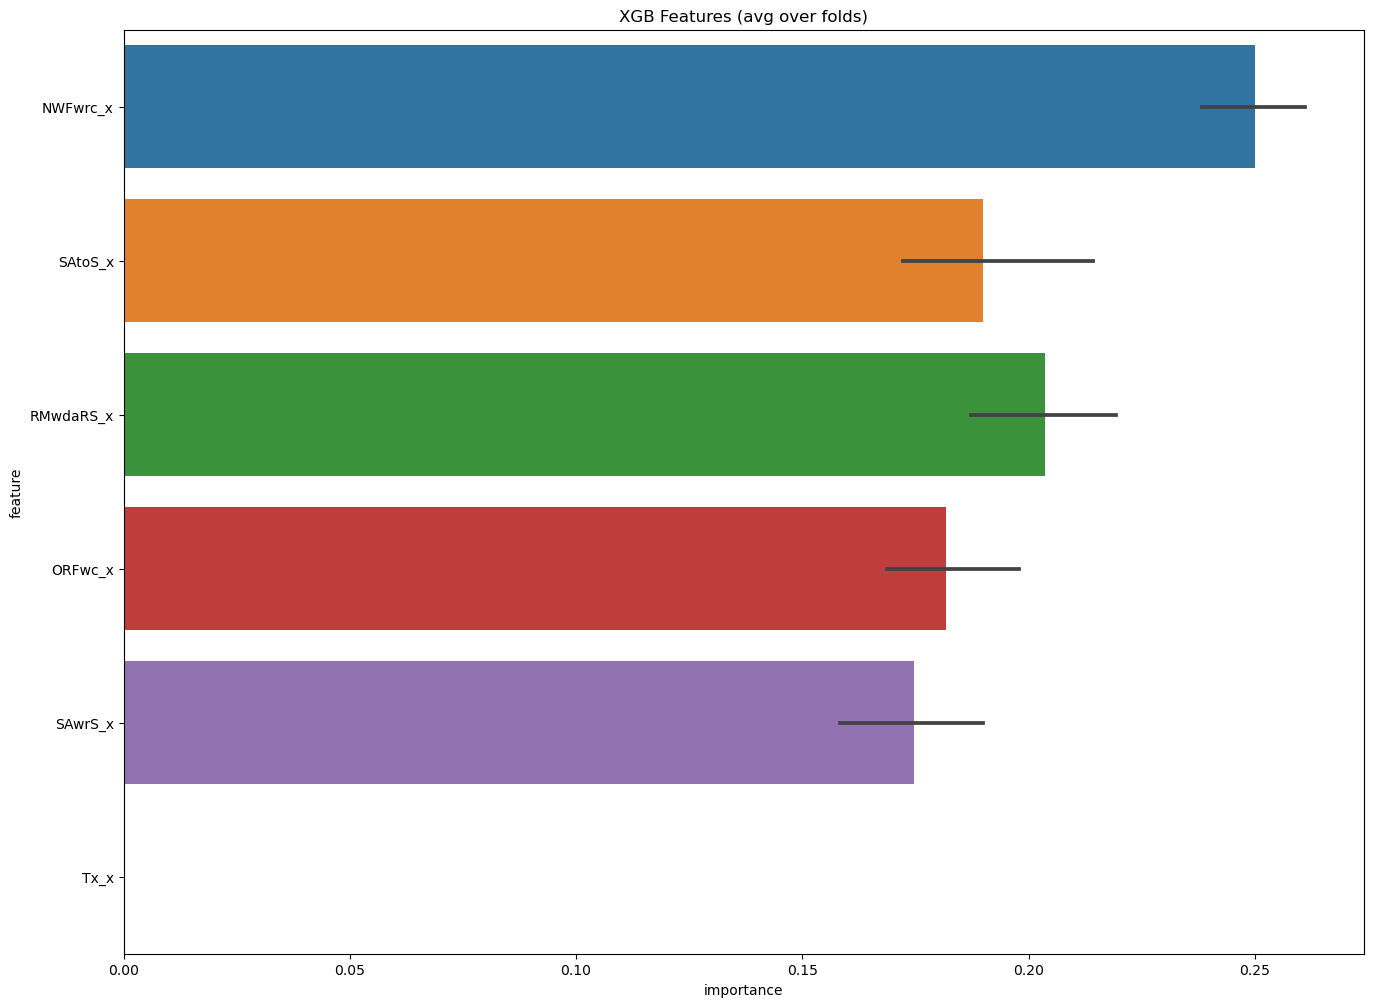

In [25]:
gkf = GroupKFold(n_splits = 5)

target = "RMwdaRS_target" #"RMwdaRS_target" #"RMwidRS_target"
feature_importance = pd.DataFrame()
accuracy, specificity, sensitivity, balanced_score = 0, 0, 0, 0
fig, ax = plt.subplots()

for fold_n, (train_idx, val_idx) in enumerate(gkf.split(data_intn[selected_features_wda], data_intn[target], groups=data_intn.StuID)):
    X_train, y_train = data_intn[selected_features_wda].iloc[train_idx], data_intn[target].iloc[train_idx]
    X_valid, y_valid = data_intn[selected_features_wda].iloc[val_idx], data_intn[target].iloc[val_idx]
    
    print("="*25)
    print(f"fold {fold_n} training, target :{target}")
    
    model = xgb.XGBClassifier(**params, n_estimators = 5000, nthread = 4, n_jobs = -1)
    model.fit(X_train, y_train, 
               eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='auc',
               verbose=1000, early_stopping_rounds=2000)
    
    y_pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    ba = balanced_accuracy_score(y_valid, y_pred)
    prec,recall,_,_ = precision_recall_fscore_support(y_valid, y_pred, pos_label=True,average=None, labels = [0,1], zero_division=0)
    print(f"accuracy:{acc}, specificity: {recall[0]}, sensitivity:{recall[1]}, balanced_score: {ba}")
    
    accuracy += acc
    specificity += recall[0]
    sensitivity += recall[1]
    balanced_score += ba
    
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = selected_features_wda
    fold_importance["importance"] = model.feature_importances_
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
#     RocCurveDisplay.from_predictions(y_pred, y_valid)
    RocCurveDisplay.from_estimator(model, X_valid, y_valid, ax=ax, name=f"fold {fold_n}")

plt.show()

print(f"accuracy:{accuracy/5}, specificity: {specificity/5}, sensitivity:{sensitivity/5}, balanced_score: {balanced_score/5}")

cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 12));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('XGB Features (avg over folds)');